# Unified EDA: Hospital, Transactions, Patients, Inventory & Supply Chain

This notebook:
1. Loads **all sheets** from provided Excel files
2. Merges into a **single master dataset** keyed on IDs
3. Performs **EDA** across:
   - Transactions
   - Products
   - Patients
   - Hospitals / Departments
   - Adherence & Bounce
   - Inventory & Supply Chain
4. Ends with a **Summary KPI section**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style='whitegrid', palette='Set2')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)

## 1. Load All Excel Sheets

In [2]:
base_path = Path('.')
files = {
    'Hospital_Dataset': base_path / 'Hospital_Dataset.xlsx',
    'Inventory': base_path / 'Inventory.xlsx',
    'Patients': base_path / 'Patients.xlsx',
    'Supply_Chain': base_path / 'Supply_Chain.xlsx',
    'Transactions_2023': base_path / 'Transactions_2023.xlsx',
    'Transactions_2024': base_path / 'Transactions_2024.xlsx',
}

def as_str(s):
    try:
        return s.astype('string').astype('string')
    except Exception:
        return s.astype(str)

# Hospital Dataset
hd = pd.ExcelFile(files['Hospital_Dataset'])
df_hospital    = pd.read_excel(hd, 'Hospital')
df_departments = pd.read_excel(hd, 'Departments')
df_physicians  = pd.read_excel(hd, 'Physicians')
df_skus        = pd.read_excel(hd, 'SKUs')
df_vendors     = pd.read_excel(hd, 'Vendors')

# Inventory
inv = pd.ExcelFile(files['Inventory'])
df_inventory = pd.read_excel(inv, inv.sheet_names[0])

# Patients
pat = pd.ExcelFile(files['Patients'])
df_patients = pd.read_excel(pat, pat.sheet_names[0])

# Supply Chain
sc = pd.ExcelFile(files['Supply_Chain'])
df_pos        = pd.read_excel(sc, 'Purchase_Orders')
df_deliveries = pd.read_excel(sc, 'Deliveries')

# Transactions
tx23 = pd.read_excel(files['Transactions_2023'])
tx24 = pd.read_excel(files['Transactions_2024'])
df_tx = pd.concat([tx23, tx24], ignore_index=True)

# Convert IDs consistently
for d in [df_hospital, df_departments, df_physicians, df_skus, df_vendors,
          df_inventory, df_patients, df_pos, df_deliveries, df_tx]:
    for col in [c for c in d.columns if c.endswith('_id') or c in ['sku_id','vendor_id','hospital_id','dept_id','physician_id','patient_id']]:
        d[col] = as_str(d[col])

# Dates
if 'transaction_date' in df_tx.columns:
    df_tx['transaction_date'] = pd.to_datetime(df_tx['transaction_date'], errors='coerce')
for c in ['po_date','requested_delivery_date']:
    if c in df_pos.columns:
        df_pos[c] = pd.to_datetime(df_pos[c], errors='coerce')
for c in ['delivery_date','expiry_date']:
    if c in df_deliveries.columns:
        df_deliveries[c] = pd.to_datetime(df_deliveries[c], errors='coerce')

df_tx.head()

,transaction_id,hospital_id,dept_id,physician_id,patient_id,sku_id,transaction_date,transaction_time,quantity_consumed,unit_cost,total_cost,transaction_type,formulary_adherent,adherence_impact_pct,bounced,bounce_reason,revenue_lost,patient_complexity_score,seasonal_factor,urgency_level
0,T00000018,H001,D001,P0009,PT000003,SKU00486,2023-11-18,09:35,5.24,186.374047,976.60,Prescription,False,32.9,False,NaN,0.0,0.8,1.05,Emergency
1,T00000019,H001,D001,P0001,PT000003,SKU01075,2023-11-18,20:51,3.00,11.110000,33.33,Procedure,True,0.0,False,NaN,0.0,0.8,1.05,Urgent
2,T00000020,H001,D001,P0001,PT000003,SKU00399,2023-11-18,09:57,0.84,9.416928,7.91,Prescription,False,38.5,False,NaN,0.0,0.8,1.05,Emergency
3,T00000021,H001,D001,P0001,PT000003,SKU00422,2023-11-18,15:24,1.03,17.957942,18.50,Prescription,False,28.2,False,NaN,0.0,0.8,1.05,Emergency
4,T00000022,H001,D001,P0007,PT000003,SKU00730,2023-11-18,08:30,3.12,67.611162,210.95,Prescription,False,25.5,False,NaN,0.0,0.8,1.05,Urgent


## 2. Merge into Master Dataset

In [3]:
# Supply Chain merge
common_keys = [k for k in ['po_id','sku_id','vendor_id'] if k in df_pos.columns and k in df_deliveries.columns]
if common_keys:
    scm = pd.merge(df_pos, df_deliveries, on=common_keys, how='left', suffixes=('_po','_dlv'))
else:
    join_keys = [c for c in ['sku_id','vendor_id'] if c in df_pos.columns and c in df_deliveries.columns]
    scm = pd.merge(df_pos, df_deliveries, on=join_keys, how='left', suffixes=('_po','_dlv'))

if 'delivery_date' in scm.columns and 'po_date' in scm.columns:
    scm['lead_time_days'] = (scm['delivery_date'] - scm['po_date']).dt.days

if 'delivery_date' in scm.columns and 'requested_delivery_date' in scm.columns:
    scm['on_time'] = (scm['delivery_date'] <= scm['requested_delivery_date'])

grp_keys = [k for k in ['sku_id','vendor_id'] if k in scm.columns]
sc_sku = scm.groupby(grp_keys).agg(
    avg_lead_time=('lead_time_days','mean'),
    on_time_rate=('on_time', lambda x: np.nan if x.isna().all() else x.mean()),
    orders=('po_date','count'),
    delivered=('delivery_date', lambda x: (~x.isna()).sum())
).reset_index()

# Build master dataset
master = df_tx.copy()
master = master.merge(df_skus.add_prefix('sku_').rename(columns={'sku_sku_id':'sku_id'}), on='sku_id', how='left')
master = master.merge(df_patients.add_prefix('pat_').rename(columns={'pat_patient_id':'patient_id'}), on='patient_id', how='left')
master = master.merge(df_physicians.add_prefix('phys_').rename(columns={'phys_physician_id':'physician_id'}), on='physician_id', how='left')
master = master.merge(df_departments.add_prefix('dept_').rename(columns={'dept_dept_id':'dept_id'}), on='dept_id', how='left')
master = master.merge(df_hospital.add_prefix('hosp_').rename(columns={'hosp_hospital_id':'hospital_id'}), on='hospital_id', how='left')

# Vendors
if 'sku_vendor_id' in master.columns:
    master = master.merge(df_vendors.add_prefix('vend_').rename(columns={'vend_vendor_id':'sku_vendor_id'}), on='sku_vendor_id', how='left')

# Inventory
inv_keys = [k for k in ['sku_id','hospital_id'] if k in df_inventory.columns and k in master.columns]
if inv_keys:
    master = master.merge(df_inventory.add_prefix('inv_').rename(columns={'inv_'+k:k for k in inv_keys}), on=inv_keys, how='left')

# Supply chain KPIs
if 'sku_vendor_id' in master.columns and 'vendor_id' in sc_sku.columns and 'vendor_id' not in master.columns:
    master = master.rename(columns={'sku_vendor_id':'vendor_id'})
join_keys = [k for k in ['sku_id','vendor_id'] if k in master.columns and k in sc_sku.columns]
master = master.merge(sc_sku, on=join_keys, how='left')

print(master.shape)
master.head()

(2633956, 89)


,transaction_id,hospital_id,dept_id,physician_id,patient_id,sku_id,transaction_date,transaction_time,quantity_consumed,unit_cost,total_cost,transaction_type,formulary_adherent,adherence_impact_pct,bounced,bounce_reason,revenue_lost,patient_complexity_score,seasonal_factor,urgency_level,sku_sku_name,sku_category,sku_sub_category,sku_therapeutic_area,sku_brand_generic_flag,sku_unit_of_measure,sku_standard_cost,sku_shelf_life_days,sku_storage_requirements,sku_controlled_substance_flag,sku_halal_certified,sku_base_drug_name,sku_consumption_volatility,sku_criticality_level,sku_formulary_status,sku_price_sensitivity,pat_hospital_id,pat_age_group,pat_patient_type,pat_chronic_conditions,pat_insurance_type,pat_socioeconomic_level,pat_admission_date,pat_discharge_date,pat_length_of_stay,pat_primary_dept_id,pat_complexity_score,phys_hospital_id,phys_primary_dept_id,phys_specialty,phys_experience_years,phys_nationality,phys_employment_type,phys_prescribing_preference,phys_formulary_adherence_score,phys_cost_consciousness,phys_prescription_volume,dept_hospital_id,dept_dept_name,dept_dept_type,dept_bed_count,dept_monthly_budget,dept_head_physician_id,hosp_hospital_name,hosp_hospital_type,hosp_country,hosp_city,hosp_bed_capacity,hosp_annual_budget,hosp_establishment_year,inv_inventory_id,inv_vendor_id,inv_current_stock,inv_reorder_level,inv_max_stock_level,inv_stock_status,inv_days_of_stock,inv_estimated_daily_consumption,inv_last_order_date,inv_expiry_date,inv_days_to_expiry,inv_batch_number,inv_stock_value,inv_turnover_rate,vendor_id,avg_lead_time,on_time_rate,orders,delivered
0,T00000018,H001,D001,P0009,PT000003,SKU00486,2023-11-18,09:35,5.24,186.374047,976.60,Prescription,False,32.9,False,NaN,0.0,0.8,1.05,Emergency,Paracetamol 50mg Tablet (Brand),Pharmacy,CNS/Pain Management,CNS/Pain Management,Brand,Pack,140.24,798,Room_Temp,False,True,Paracetamol,0.20,Medium,Restricted,0.438118,H001,0-18,Emergency,NaN,Private,High,2023-11-18,2023-11-18 09:36:00,0.4,D001,0.8,H001,D001,Emergency Medicine,22,Pakistani,Consultant,Generic,0.7,Low,Medium,H001,Emergency Medicine,Clinical,80,1440000,P0002,KAMC,Government,Saudi,Riyadh,800,960000000,2000,INV000486,V003,30.63,67.25,242.56,Critical_Low,18.2,1.68,2025-07-28 12:31:01.634,2027-10-30 12:31:01.634,798,B20256358,4295.99,20.03,V003,20.714286,0.0,7,7
1,T00000018,H001,D001,P0009,PT000003,SKU00486,2023-11-18,09:35,5.24,186.374047,976.60,Prescription,False,32.9,False,NaN,0.0,0.8,1.05,Emergency,Paracetamol 50mg Tablet (Brand),Pharmacy,CNS/Pain Management,CNS/Pain Management,Brand,Pack,140.24,798,Room_Temp,False,True,Paracetamol,0.20,Medium,Restricted,0.438118,H001,0-18,Emergency,NaN,Private,High,2023-11-18,2023-11-18 09:36:00,0.4,D001,0.8,H001,D001,Emergency Medicine,22,Pakistani,Consultant,Generic,0.7,Low,Medium,H001,Emergency Medicine,Clinical,80,1440000,P0002,KAMC,Government,Saudi,Riyadh,800,960000000,2000,INV000486,V003,30.63,67.25,242.56,Critical_Low,18.2,1.68,2025-07-28 12:31:01.634,2027-10-30 12:31:01.634,798,B20256358,4295.99,20.03,V008,61.000000,0.0,1,1
2,T00000019,H001,D001,P0001,PT000003,SKU01075,2023-11-18,20:51,3.00,11.110000,33.33,Procedure,True,0.0,False,NaN,0.0,0.8,1.05,Urgent,Antiseptics - Medium,Consumables,Wound Care,NaN,NaN,Package,11.11,950,Room_Temp,False,True,NaN,0.18,Standard,NaN,0.517085,H001,0-18,Emergency,NaN,Private,High,2023-11-18,2023-11-18 09:36:00,0.4,D001,0.8,H001,D001,Emergency Medicine,3,Indian,Specialist,Generic,0.9,High,High,H001,Emergency Medicine,Clinical,80,1440000,P0002,KAMC,Government,Saudi,Riyadh,800,960000000,2000,INV001075,V026,16.66,276.86,865.40,Critical_Low,1.7,9.89,2025-08-10 12:31:02.312,2028-03-30 12:31:02.312,950,B20251140,185.14,216.57,V009,16.000000,1.0,1,1
3,T00000019,H001,D001,P0001,PT000003,SKU01075,2023-11-18,20:51,3.00,11.110000,33.33,Procedure,True,0.0,False,NaN,0.0,0.8,1.05,Urgent,Antiseptics - Medium,Consumables,Wound Care,NaN,NaN,Package,11.11,950,Room_Temp,False,True,NaN,0.18,Standard,NaN,0.517085,H001,0-18,Emergency,NaN,Private,High,2023-11-18,2

## 3. EDA: Overview & Missingness

In [4]:
print('Rows:', len(master), '| Columns:', len(master.columns))
display(master.sample(5))

na = master.isna().mean().sort_values(ascending=False)
na.head(20)

Rows: 2633956 | Columns: 89


,transaction_id,hospital_id,dept_id,physician_id,patient_id,sku_id,transaction_date,transaction_time,quantity_consumed,unit_cost,total_cost,transaction_type,formulary_adherent,adherence_impact_pct,bounced,bounce_reason,revenue_lost,patient_complexity_score,seasonal_factor,urgency_level,sku_sku_name,sku_category,sku_sub_category,sku_therapeutic_area,sku_brand_generic_flag,sku_unit_of_measure,sku_standard_cost,sku_shelf_life_days,sku_storage_requirements,sku_controlled_substance_flag,sku_halal_certified,sku_base_drug_name,sku_consumption_volatility,sku_criticality_level,sku_formulary_status,sku_price_sensitivity,pat_hospital_id,pat_age_group,pat_patient_type,pat_chronic_conditions,pat_insurance_type,pat_socioeconomic_level,pat_admission_date,pat_discharge_date,pat_length_of_stay,pat_primary_dept_id,pat_complexity_score,phys_hospital_id,phys_primary_dept_id,phys_specialty,phys_experience_years,phys_nationality,phys_employment_type,phys_prescribing_preference,phys_formulary_adherence_score,phys_cost_consciousness,phys_prescription_volume,dept_hospital_id,dept_dept_name,dept_dept_type,dept_bed_count,dept_monthly_budget,dept_head_physician_id,hosp_hospital_name,hosp_hospital_type,hosp_country,hosp_city,hosp_bed_capacity,hosp_annual_budget,hosp_establishment_year,inv_inventory_id,inv_vendor_id,inv_current_stock,inv_reorder_level,inv_max_stock_level,inv_stock_status,inv_days_of_stock,inv_estimated_daily_consumption,inv_last_order_date,inv_expiry_date,inv_days_to_expiry,inv_batch_number,inv_stock_value,inv_turnover_rate,vendor_id,avg_lead_time,on_time_rate,orders,delivered
683884,T00574714,H001,D003,P0023,PT026154,SKU00193,2023-10-26,03:39,2.57,88.560000,227.60,Prescription,True,0.0,False,NaN,0.0,1.04,1.05,Urgent,Lisinopril 50mg Tablet (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,88.56,1522,Room_Temp,False,False,Lisinopril,0.12,High,Preferred,0.309982,H001,0-18,Outpatient,Hypertension,Government,High,2023-10-26,2023-10-26 04:48:00,0.2,D003,1.04,H001,D003,Cardiology,14,Indian,Consultant,Brand,0.74,Low,Medium,H001,Cardiology,Clinical,96,2112000,P0019,KAMC,Government,Saudi,Riyadh,800,960000000,2000,INV000193,V008,44.37,101.00,316.58,Critical_Low,6.2,7.21,2025-08-16 12:31:01.199,2029-10-23 12:31:01.199,1522,B20255787,3929.12,59.35,V008,59.25,0.000,8,8
287680,T00239424,H001,D009,P0095,PT010859,SKU00643,2023-07-26,10:02,1.93,54.860004,105.88,Prescription,False,39.4,False,NaN,0.0,2.10,0.90,Normal,Bevacizumab 100mg Cream (Generic),Pharmacy,Oncology/Specialty,Oncology/Specialty,Generic,Pack,39.36,1065,Room_Temp,False,True,Bevacizumab,0.35,Critical,Preferred,0.621122,H001,65+,Inpatient,NaN,Private,High,2023-07-20,2023-08-01 00:00:00,12.0,D009,2.10,H001,D009,Gynecology,5,Saudi,Specialist,Generic,0.94,Low,Medium,H001,Obstetrics & Gynecology,Clinical,56,840000,P0097,KAMC,Government,Saudi,Riyadh,800,960000000,2000,INV000643,V006,21.55,257.09,690.86,Critical_Low,5.0,4.28,2025-07-18 12:31:01.811,2028-07-23 12:31:01.811,1065,B20253549,848.03,72.59,V006,8.50,0.625,8,8
1167997,T00978118,H001,D002,P0016,PT044747,SKU00324,2023-10-12,16:41,2.75,13.150000,36.16,Prescription,True,0.0,False,NaN,0.0,1.30,1.05,Normal,Lisinopril 500mg Cream (Generic),Pharmacy,Cardiovascular,Cardiovascular,Generic,Pack,13.15,564,Refrigerated,False,True,Lisinopril,0.12,High,Non-Preferred,0.607631,H001,19-35,Inpatient,Diabetes,Government,High,2023-10-11,2023-10-13 16:48:00,2.7,D002,1.30,H001,D002,Internal Medicine,8,Saudi,Specialist,Generic,0.81,High,Medium,H001,Internal Medicine,Clinical,144,1728000,P0011,KAMC,Government,Saudi,Riyadh,800,960000000,2000,INV000324,V010,66.86,87.00,255.12,Low,31.5,2.12,2025-07-15 12:31:01.345,2027-03-10 12:31:01.345,564,B20259142,879.26,11.58,V010,21.00,0.000,5,5
1239852,T01040721,H001,D003,P0025,PT047659,SKU00219,2023-08-29,11:59,8.54,60.370000,515.56,Prescription,True,0.0,False,NaN,0.0,1.82,0.90,Normal,Atorvastatin 25mg Tablet (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,60.37,864,Freezer,False,True,Atorvastatin,0.12,High,P

,0
bounce_reason,0.892735
pat_chronic_conditions,0.353750
sku_therapeutic_area,0.221695
sku_base_drug_name,0.221695
sku_brand_generic_flag,0.221695
sku_formulary_status,0.221695
sku_id,0.000000
hospital_id,0.000000
patient_id,0.000000
quantity_consumed,0.000000


## 4. Time Trends

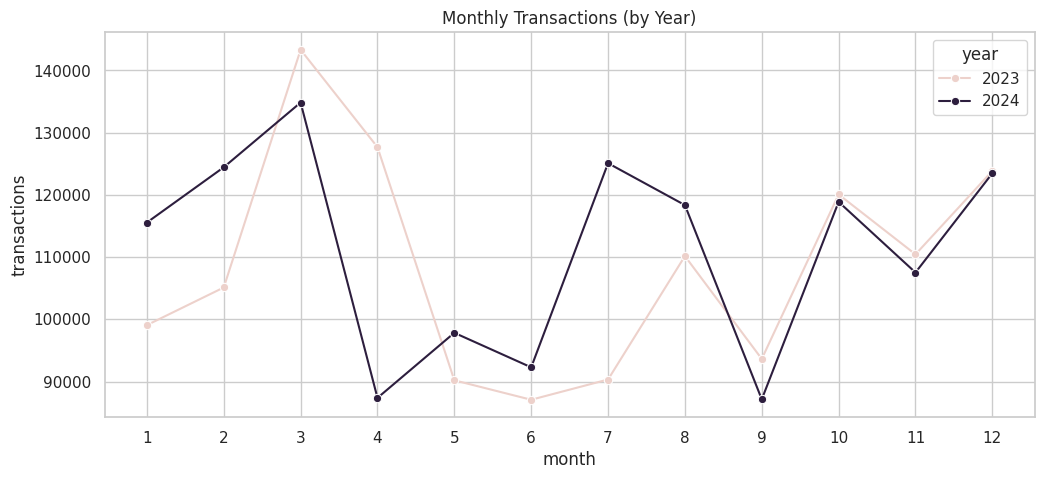

In [5]:
if 'transaction_date' in master.columns:
    master['year']  = master['transaction_date'].dt.year
    master['month'] = master['transaction_date'].dt.month

    monthly = master.groupby(['year','month']).agg(
        transactions=('transaction_id','count'),
        total_cost=('total_cost','sum')
    ).reset_index()

    plt.figure(figsize=(12,5))
    sns.lineplot(data=monthly, x='month', y='transactions', hue='year', marker='o')
    plt.title('Monthly Transactions (by Year)')
    plt.xticks(range(1,13))
    plt.show()

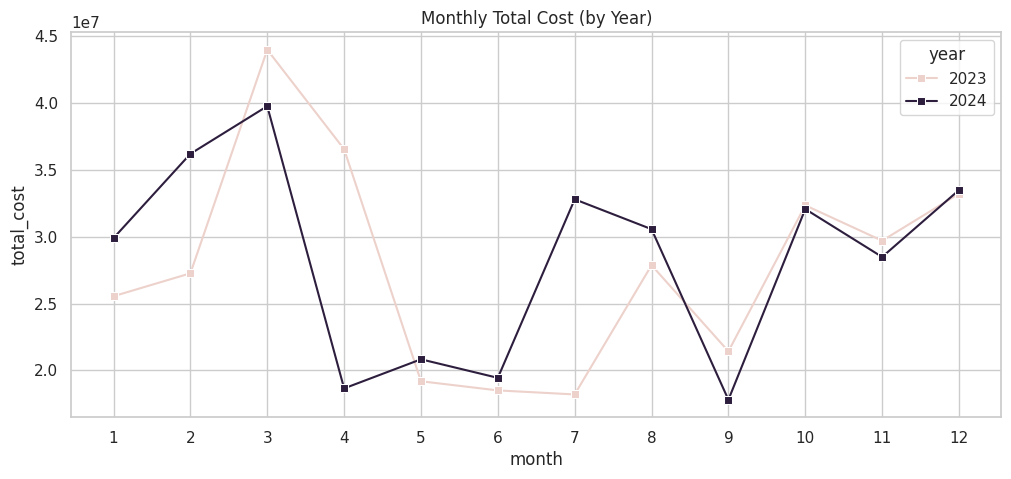

In [6]:

    plt.figure(figsize=(12,5))
    sns.lineplot(data=monthly, x='month', y='total_cost', hue='year', marker='s')
    plt.title('Monthly Total Cost (by Year)')
    plt.xticks(range(1,13))
    plt.show()

## 5. Department & Hospital

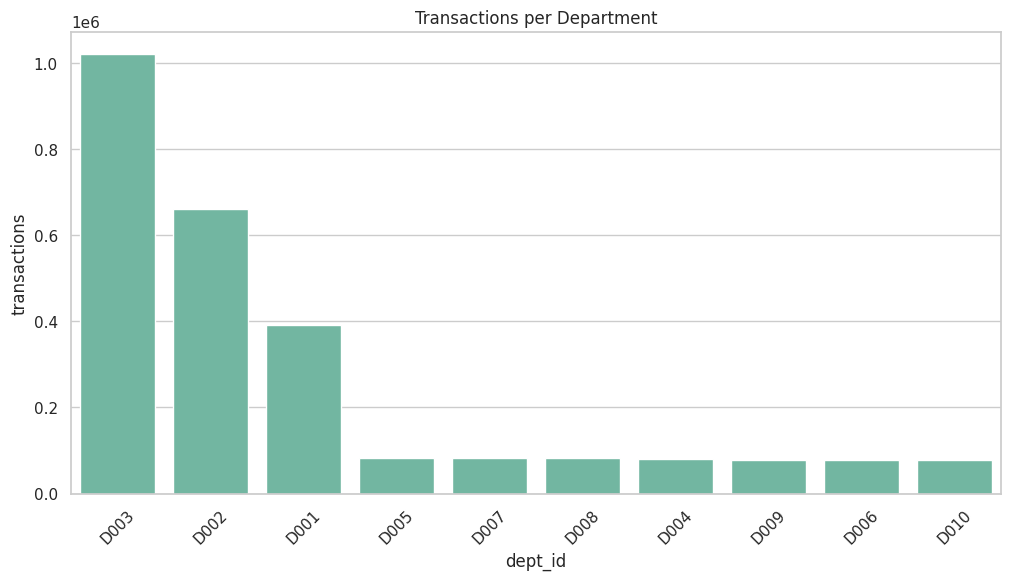

,transaction_id
hosp_hospital_name,
KAMC,2633956


In [7]:
if 'dept_id' in master.columns:
    dept_trends = master.groupby('dept_id')['transaction_id'].count().reset_index(name='transactions').sort_values('transactions', ascending=False)
    plt.figure(figsize=(12,6))
    sns.barplot(data=dept_trends, x='dept_id', y='transactions')
    plt.title('Transactions per Department')
    plt.xticks(rotation=45)
    plt.show()

if 'hosp_hospital_name' in master.columns:
    display(master.groupby('hosp_hospital_name')['transaction_id'].count().sort_values(ascending=False))

## 6. Product Analysis

,sku_id,transaction_count
391,SKU00392,14790
304,SKU00305,10626
335,SKU00336,9904
370,SKU00371,9832
366,SKU00367,9756
379,SKU00380,9728
378,SKU00379,9700
386,SKU00387,9632
394,SKU00395,9528
285,SKU00286,8550


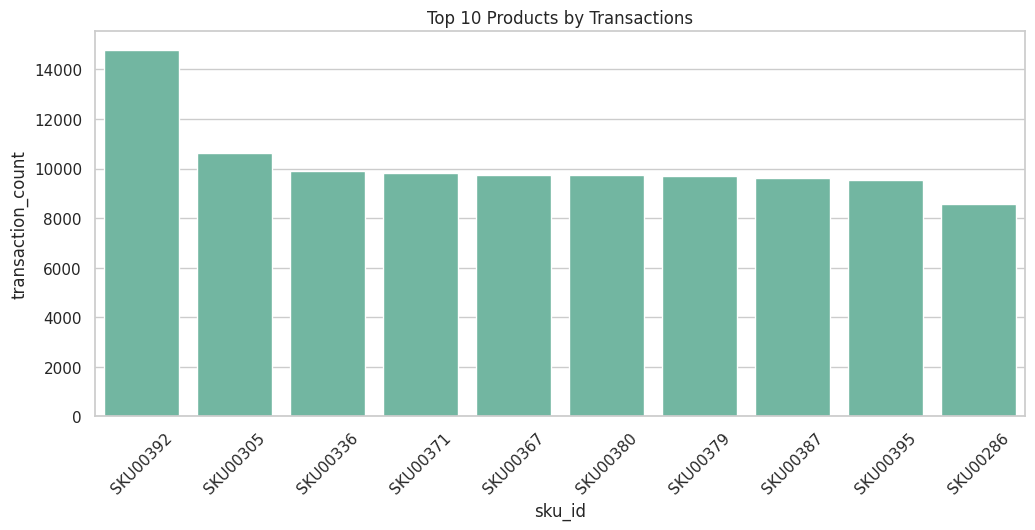

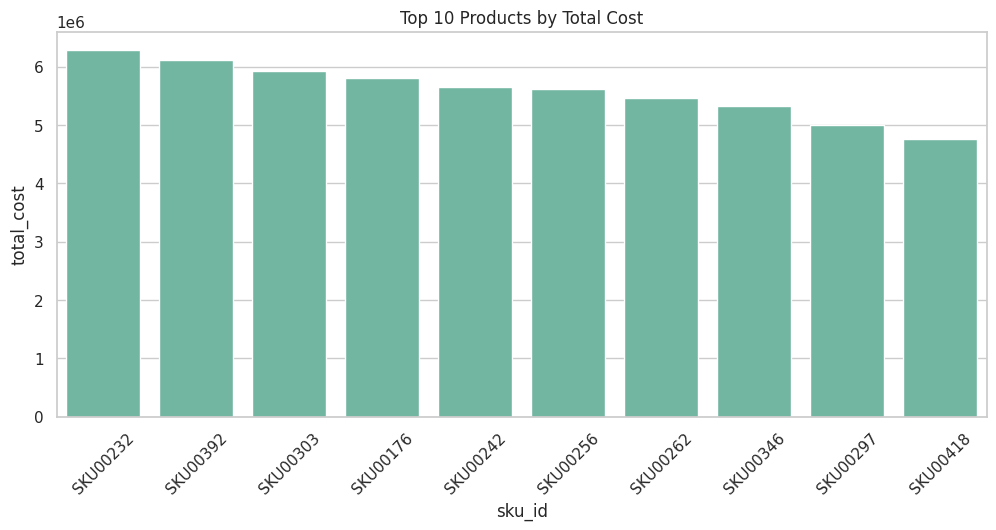

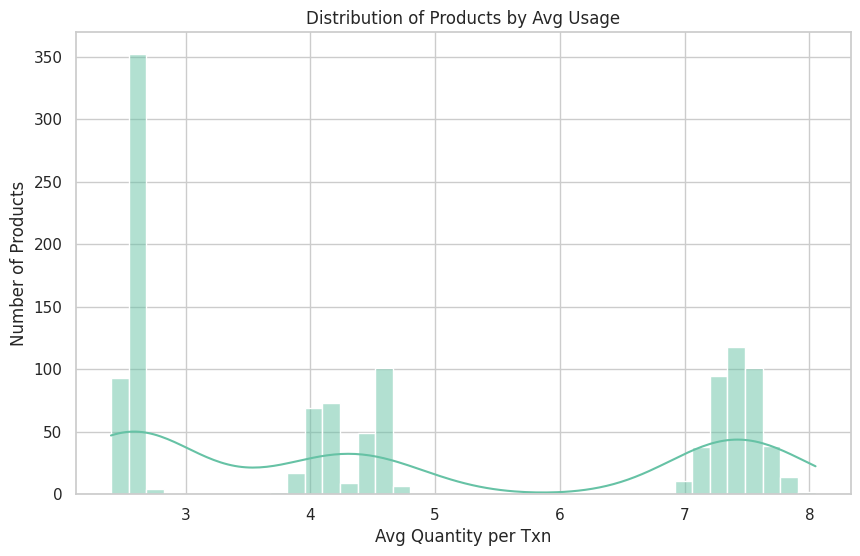

In [8]:
prod_count = master.groupby('sku_id')['transaction_id'].count().reset_index(name='transaction_count').sort_values('transaction_count', ascending=False)
display(prod_count.head(10))

plt.figure(figsize=(12,5))
sns.barplot(data=prod_count.head(10), x='sku_id', y='transaction_count')
plt.title('Top 10 Products by Transactions')
plt.xticks(rotation=45)
plt.show()

prod_cost = master.groupby('sku_id')['total_cost'].sum().reset_index().sort_values('total_cost', ascending=False)
plt.figure(figsize=(12,5))
sns.barplot(data=prod_cost.head(10), x='sku_id', y='total_cost')
plt.title('Top 10 Products by Total Cost')
plt.xticks(rotation=45)
plt.show()

if 'quantity_consumed' in master.columns:
    product_usage = master.groupby('sku_id')['quantity_consumed'].mean().reset_index()
    plt.figure(figsize=(10,6))
    sns.histplot(product_usage['quantity_consumed'], bins=40, kde=True)
    plt.title('Distribution of Products by Avg Usage')
    plt.xlabel('Avg Quantity per Txn')
    plt.ylabel('Number of Products')
    plt.show()

## 7. Transaction Type Analysis

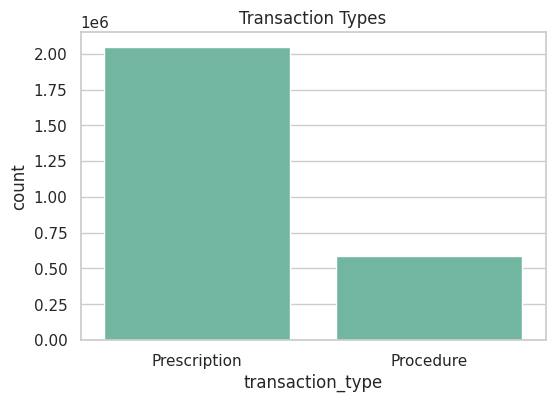

,transaction_type,transactions,total_cost,avg_qty
0,Prescription,2050021,4.934120e+08,3.384240
1,Procedure,583935,1.803141e+08,7.423948


In [9]:
if 'transaction_type' in master.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=master, x='transaction_type')
    plt.title('Transaction Types')
    plt.show()

    by_type = master.groupby('transaction_type').agg(
        transactions=('transaction_id','count'),
        total_cost=('total_cost','sum'),
        avg_qty=('quantity_consumed','mean')
    ).reset_index()
    display(by_type)

## 8. Adherence & Bounce Analysis

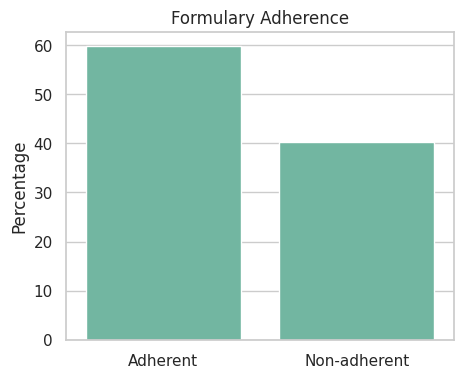

In [10]:
if 'formulary_adherent' in master.columns:
    rate = master['formulary_adherent'].mean()*100
    plt.figure(figsize=(5,4))
    sns.barplot(x=['Adherent','Non-adherent'], y=[rate, 100-rate])
    plt.ylabel('Percentage')
    plt.title('Formulary Adherence')
    plt.show()


Overall Bounce Rate: 10.73%


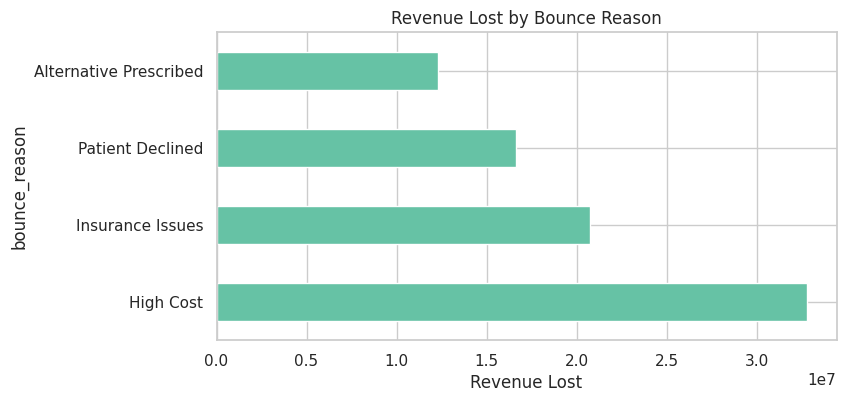

In [11]:

if {'bounced','revenue_lost'}.issubset(master.columns):
    print(f'Overall Bounce Rate: {master["bounced"].mean()*100:.2f}%')
    br = master.groupby('bounce_reason')['revenue_lost'].sum().sort_values(ascending=False)
    if not br.empty:
        br.plot(kind='barh', figsize=(8,4), title='Revenue Lost by Bounce Reason')
        plt.xlabel('Revenue Lost')
        plt.show()

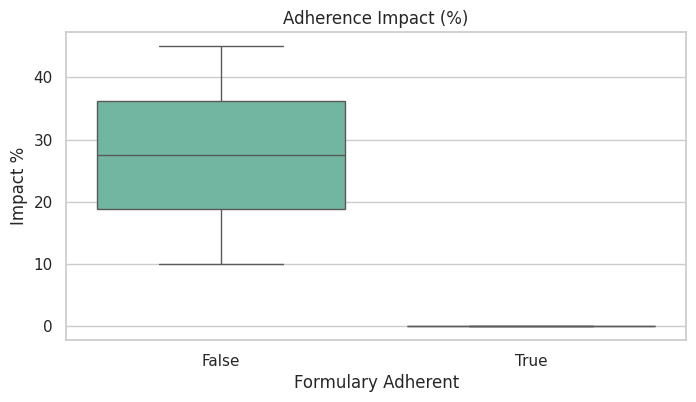

In [12]:

if {'adherence_impact_pct','formulary_adherent'}.issubset(master.columns):
    plt.figure(figsize=(8,4))
    sns.boxplot(data=master, x='formulary_adherent', y='adherence_impact_pct')
    plt.title('Adherence Impact (%)')
    plt.xlabel('Formulary Adherent')
    plt.ylabel('Impact %')
    plt.show()

## 9. Patient Analysis

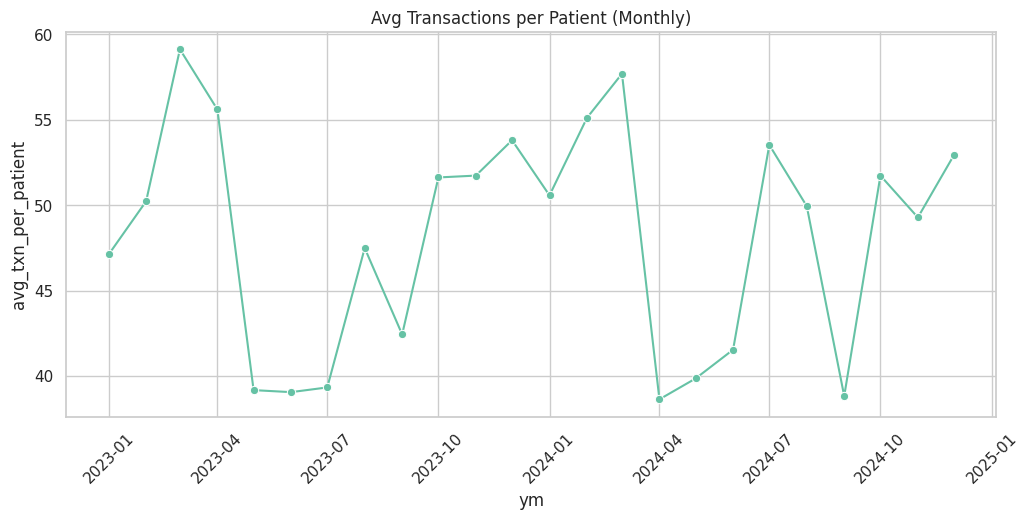

In [13]:
if 'transaction_date' in master.columns:
    tmp = master.copy()
    tmp['ym'] = tmp['transaction_date'].dt.to_period('M')
    pt = tmp.groupby('ym').agg(
        transactions=('transaction_id','count'),
        unique_patients=('patient_id','nunique')
    ).reset_index()
    pt['avg_txn_per_patient'] = pt['transactions']/pt['unique_patients']
    pt['ym'] = pt['ym'].dt.to_timestamp()

    plt.figure(figsize=(12,5))
    sns.lineplot(data=pt, x='ym', y='avg_txn_per_patient', marker='o')
    plt.title('Avg Transactions per Patient (Monthly)')
    plt.xticks(rotation=45)
    plt.show()

## 10. Inventory & Supply Chain

,avg_lead_time,on_time_rate,orders,delivered
count,2.633956e+06,2.633956e+06,2.633956e+06,2.633956e+06
mean,2.715528e+01,1.418575e-01,4.311940e+00,4.311940e+00
std,2.027361e+01,2.313975e-01,3.269579e+00,3.269579e+00
min,6.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.300000e+01,0.000000e+00,1.000000e+00,1.000000e+00
50%,2.016667e+01,0.000000e+00,3.000000e+00,3.000000e+00
75%,3.050000e+01,2.307692e-01,7.000000e+00,7.000000e+00
max,1.500000e+02,1.000000e+00,1.500000e+01,1.500000e+01


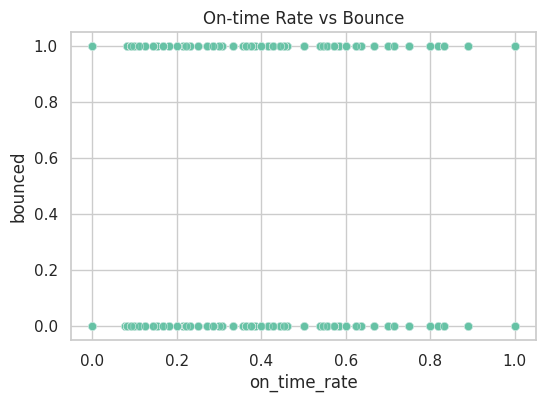

In [14]:
sc_cols = [c for c in ['avg_lead_time','on_time_rate','orders','delivered'] if c in master.columns]
if sc_cols:
    display(master[sc_cols].describe())
    if 'on_time_rate' in master.columns and 'bounced' in master.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=master, x='on_time_rate', y='bounced', alpha=0.2)
        plt.title('On-time Rate vs Bounce')
        plt.show()

## 11. Summary KPIs

In [15]:
print("=== Key KPIs Summary ===")

total_txn = master['transaction_id'].nunique()
total_cost = master['total_cost'].sum()

print(f"Total Transactions: {total_txn:,}")
print(f"Total Cost: {total_cost:,.2f}")

if 'formulary_adherent' in master.columns:
    adherence_rate = master['formulary_adherent'].mean() * 100
    print(f"Formulary Adherence Rate: {adherence_rate:.2f}%")

if 'bounced' in master.columns:
    bounce_rate = master['bounced'].mean() * 100
    print(f"Bounce Rate: {bounce_rate:.2f}%")

top_products_vol = master.groupby('sku_id')['transaction_id'].count().sort_values(ascending=False).head(3)
print("\nTop 3 Products by Transactions:")
print(top_products_vol)

top_products_cost = master.groupby('sku_id')['total_cost'].sum().sort_values(ascending=False).head(3)
print("\nTop 3 Products by Total Cost:")
print(top_products_cost)

=== Key KPIs Summary ===
Total Transactions: 1,086,985
Total Cost: 673,726,156.23
Formulary Adherence Rate: 59.71%
Bounce Rate: 10.73%

Top 3 Products by Transactions:
sku_id
SKU00392    14790
SKU00305    10626
SKU00336     9904
Name: transaction_id, dtype: int64

Top 3 Products by Total Cost:
sku_id
SKU00232    6287863.08
SKU00392    6116332.14
SKU00303    5922409.56
Name: total_cost, dtype: float64


Categorize:

Category A: Top ~70% of sales (critical, high sellers)

Category B: Next ~20% of sales (medium importance)

Category C: Remaining ~10% (low impact, long-tail items)

category
C    495
A    370
B    332
Name: count, dtype: int64


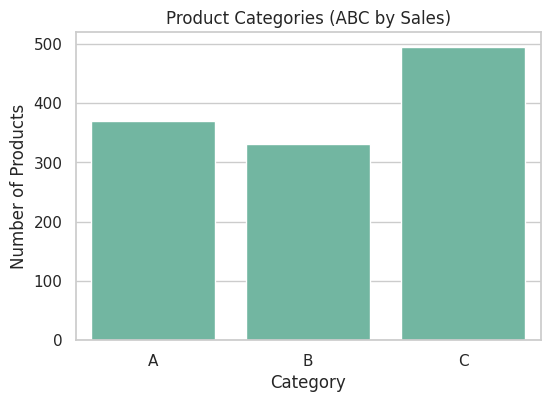

In [16]:
# Aggregate sales per product (by revenue)
sku_sales = master.groupby('sku_id')['total_cost'].sum().reset_index().sort_values('total_cost', ascending=False)

# Calculate cumulative contribution %
sku_sales['cum_pct'] = sku_sales['total_cost'].cumsum() / sku_sales['total_cost'].sum() * 100

# Categorize into A/B/C
def categorize(pct):
    if pct <= 70:
        return 'A'  # top products
    elif pct <= 90:
        return 'B'  # medium products
    else:
        return 'C'  # long-tail
sku_sales['category'] = sku_sales['cum_pct'].apply(categorize)

# Merge category back into master dataset
master = master.merge(sku_sales[['sku_id','category']], on='sku_id', how='left')

# Show distribution
print(sku_sales['category'].value_counts())

# Plot distribution
plt.figure(figsize=(6,4))
sns.countplot(data=sku_sales, x='category', order=['A','B','C'])
plt.title('Product Categories (ABC by Sales)')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.show()

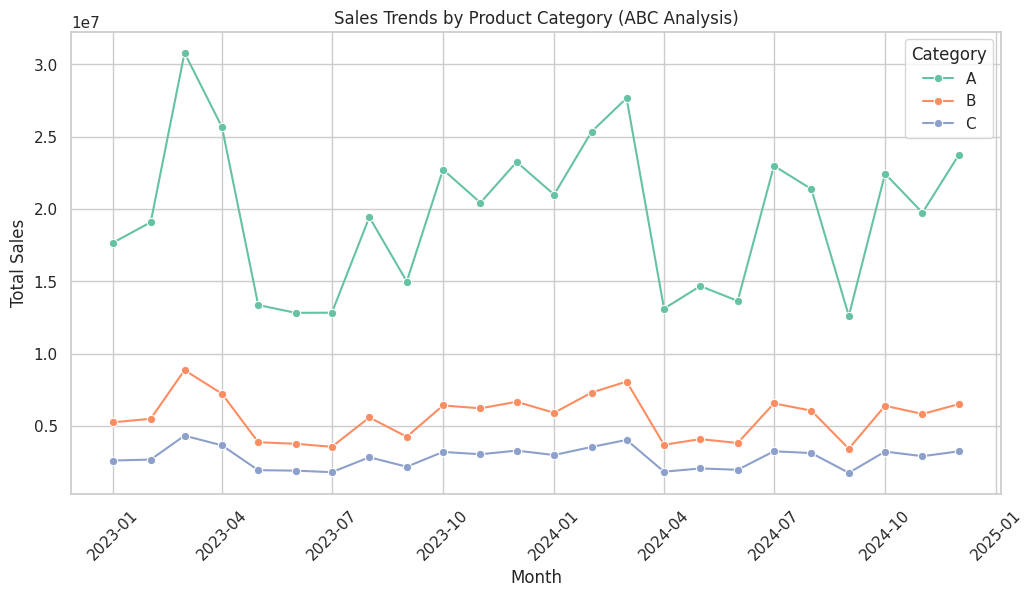

In [17]:
# --- Sales trends over time by product category ---

if 'transaction_date' in master.columns and 'category' in master.columns:
    # Extract year-month
    master['year_month'] = master['transaction_date'].dt.to_period('M').dt.to_timestamp()

    # Aggregate total sales per category over time
    category_trends = (
        master.groupby(['year_month','category'])['total_cost']
        .sum()
        .reset_index()
    )

    # Plot trends
    plt.figure(figsize=(12,6))
    sns.lineplot(data=category_trends, x='year_month', y='total_cost', hue='category', marker='o')
    plt.title('Sales Trends by Product Category (ABC Analysis)')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.show()

SKU vs Cummaltove Percnetage

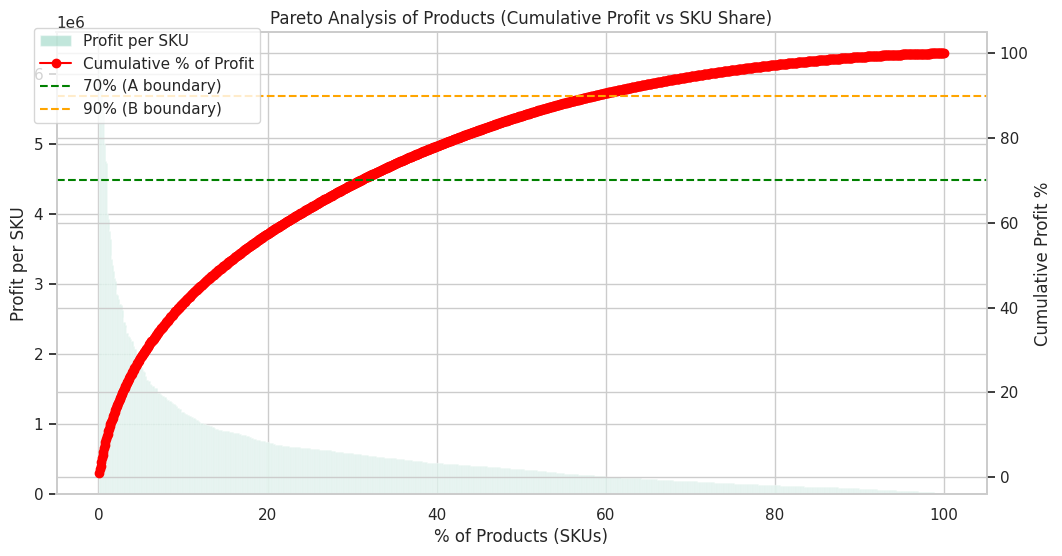

In [18]:
# Compute profit per SKU (here using total_cost, replace with 'profit' column if available)
sku_profit = master.groupby('sku_id')['total_cost'].sum().reset_index().sort_values('total_cost', ascending=False)

# Rank SKUs and compute cumulative % of products
sku_profit['sku_rank'] = range(1, len(sku_profit)+1)
sku_profit['sku_pct'] = sku_profit['sku_rank'] / len(sku_profit) * 100

# Cumulative % of profit
sku_profit['cum_profit_pct'] = sku_profit['total_cost'].cumsum() / sku_profit['total_cost'].sum() * 100

# Plot Pareto Curve
fig, ax1 = plt.subplots(figsize=(12,6))

# Bar for profit share (optional, to show distribution)
ax1.bar(sku_profit['sku_pct'], sku_profit['total_cost'], width=100/len(sku_profit), alpha=0.4, label='Profit per SKU')
ax1.set_ylabel('Profit per SKU')
ax1.set_xlabel('% of Products (SKUs)')
ax1.set_title('Pareto Analysis of Products (Cumulative Profit vs SKU Share)')

# Secondary axis for cumulative %
ax2 = ax1.twinx()
ax2.plot(sku_profit['sku_pct'], sku_profit['cum_profit_pct'], color='red', marker='o', label='Cumulative % of Profit')
ax2.set_ylabel('Cumulative Profit %')

# Reference lines at 70% and 90% (ABC thresholds)
ax2.axhline(70, color='green', linestyle='--', label='70% (A boundary)')
ax2.axhline(90, color='orange', linestyle='--', label='90% (B boundary)')

# Legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()


# Add one for 50%



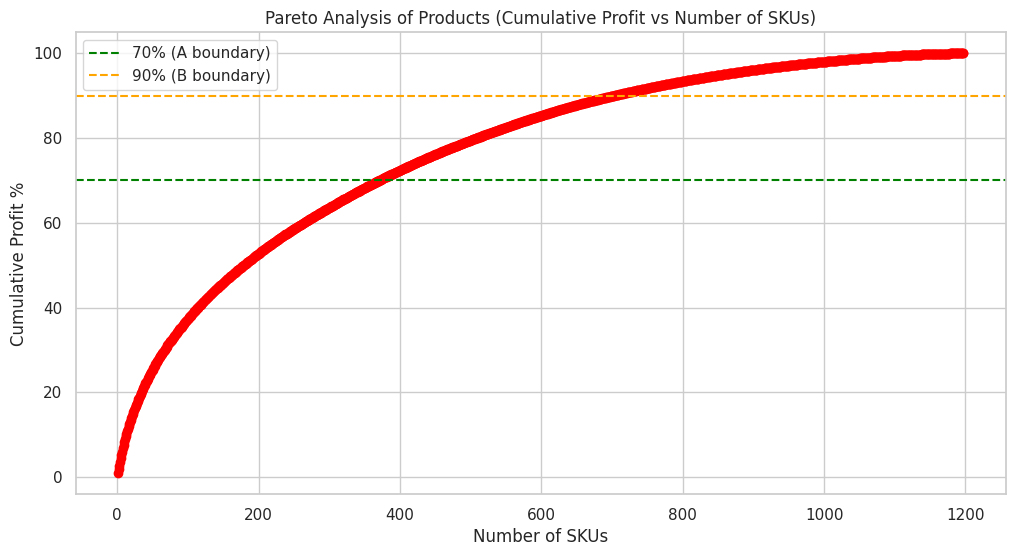

In [19]:
# Compute profit per SKU (using total_cost as proxy for profit)
sku_profit = (
    master.groupby('sku_id')['total_cost']
    .sum()
    .reset_index()
    .sort_values('total_cost', ascending=False)
)

# Rank SKUs
sku_profit['sku_rank'] = range(1, len(sku_profit)+1)

# Cumulative % of profit
sku_profit['cum_profit_pct'] = sku_profit['total_cost'].cumsum() / sku_profit['total_cost'].sum() * 100

# Plot Pareto Curve with absolute SKU counts
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(sku_profit['sku_rank'], sku_profit['cum_profit_pct'], marker='o', color='red')
ax.set_xlabel('Number of SKUs')
ax.set_ylabel('Cumulative Profit %')
ax.set_title('Pareto Analysis of Products (Cumulative Profit vs Number of SKUs)')

# Reference lines at 70% and 90% (ABC thresholds)
ax.axhline(70, color='green', linestyle='--', label='70% (A boundary)')
ax.axhline(90, color='orange', linestyle='--', label='90% (B boundary)')

ax.legend()
plt.show()

Daily SKU flow table

In [20]:
# =============================
# SKU - Day - Demand - Inflow
# =============================

# --- Step 1: Daily demand from transactions ---
sku_demand = (
    master.groupby(['sku_id', master['transaction_date'].dt.date])['quantity_consumed']
    .sum()
    .reset_index()
    .rename(columns={'transaction_date':'day', 'quantity_consumed':'demand'})
)

# --- Step 2: Daily inflow from deliveries ---
sku_inflow = (
    df_deliveries.groupby(['sku_id', df_deliveries['delivery_date'].dt.date])['accepted_quantity']
    .sum()
    .reset_index()
    .rename(columns={'delivery_date':'day', 'accepted_quantity':'inflow'})
)

# --- Step 3: Merge demand & inflow ---
sku_flow = pd.merge(sku_demand, sku_inflow, on=['sku_id','day'], how='outer')

# Fill missing values with 0
sku_flow = sku_flow.fillna({'demand':0, 'inflow':0})

# Ensure proper dtypes
sku_flow['day'] = pd.to_datetime(sku_flow['day'])

# Sort for readability
sku_flow = sku_flow.sort_values(['sku_id','day']).reset_index(drop=True)

# Final dataset
sku_flow.head(10)

,sku_id,day,demand,inflow
0,SKU00001,2022-12-21,0.00,694.99
1,SKU00001,2023-01-07,5.70,0.00
2,SKU00001,2023-01-08,9.90,0.00
3,SKU00001,2023-01-09,8.24,0.00
4,SKU00001,2023-01-10,8.54,0.00
5,SKU00001,2023-01-11,8.06,0.00
6,SKU00001,2023-01-12,19.20,0.00
7,SKU00001,2023-01-13,3.36,0.00
8,SKU00001,2023-01-19,20.00,0.00
9,SKU00001,2023-01-22,16.86,0.00


In [21]:
# Ensure data is sorted by SKU and Day
sku_flow = sku_flow.sort_values(['sku_id','day']).reset_index(drop=True)

# Initialize availability column
sku_flow['availability'] = 0

# Compute availability per SKU (running balance)
for sku in sku_flow['sku_id'].unique():
    mask = sku_flow['sku_id'] == sku
    sku_flow.loc[mask, 'availability'] = (
        sku_flow.loc[mask, ['inflow','demand']]
        .assign(prev_stock=0)
        .pipe(lambda df: (df['inflow'] - df['demand']).cumsum())
    )

sku_flow.head(15)

/tmp/ipython-input-3567169319.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  694.99   689.29   679.39   671.15   662.61   654.55   635.35   631.99
   611.99   595.13   586.31   585.17   571.85   725.23   708.67   697.01
   694.11   671.53   663.99   657.45   637.45   636.17   609.63   608.41
   598.13   577.91   567.67   551.09   545.05   530.21   498.77   472.43
   470.91   455.89   438.73   421.51   402.79   383.79   373.19   345.71
   333.21   331.77   326.49   323.75   298.49   289.15   260.71   254.03
   246.71   230.55   220.53   217.43   209.15   203.13   199.49   196.37
   178.97   169.83   165.65   151.63   145.01   141.61   971.73   961.45
   959.53   944.39   943.59   927.71   921.51   917.71   912.15   909.87
   898.05   882.69   857.99   848.77   832.39   830.39   810.73   792.57
   787.99   770.89   754.25   751.43   737.61   734.23   722.69   716.59
   708.27   706.85   697.75   6

,sku_id,day,demand,inflow,availability
0,SKU00001,2022-12-21,0.00,694.99,694.99
1,SKU00001,2023-01-07,5.70,0.00,689.29
2,SKU00001,2023-01-08,9.90,0.00,679.39
3,SKU00001,2023-01-09,8.24,0.00,671.15
4,SKU00001,2023-01-10,8.54,0.00,662.61
5,SKU00001,2023-01-11,8.06,0.00,654.55
6,SKU00001,2023-01-12,19.20,0.00,635.35
7,SKU00001,2023-01-13,3.36,0.00,631.99
8,SKU00001,2023-01-19,20.00,0.00,611.99
9,SKU00001,2023-01-22,16.86,0.00,595.13


money generated (revenue/profit per SKU)

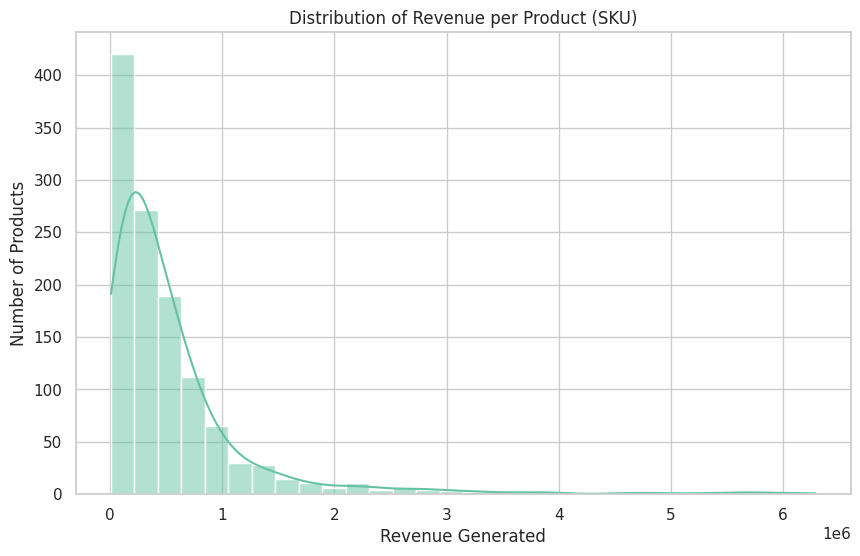

,revenue
count,1.197000e+03
mean,5.628456e+05
std,7.511936e+05
min,8.810790e+03
25%,1.552377e+05
50%,3.569103e+05
75%,6.526400e+05
max,6.287863e+06


In [22]:
# Aggregate revenue (money generated) per SKU
sku_money = master.groupby('sku_id')['total_cost'].sum().reset_index().rename(columns={'total_cost':'revenue'})

# Plot histogram with KDE (normal-like curve)
plt.figure(figsize=(10,6))
sns.histplot(sku_money['revenue'], bins=30, kde=True)
plt.title('Distribution of Revenue per Product (SKU)')
plt.xlabel('Revenue Generated')
plt.ylabel('Number of Products')
plt.show()

# Optional: Show descriptive stats
sku_money['revenue'].describe()

Department wise trned

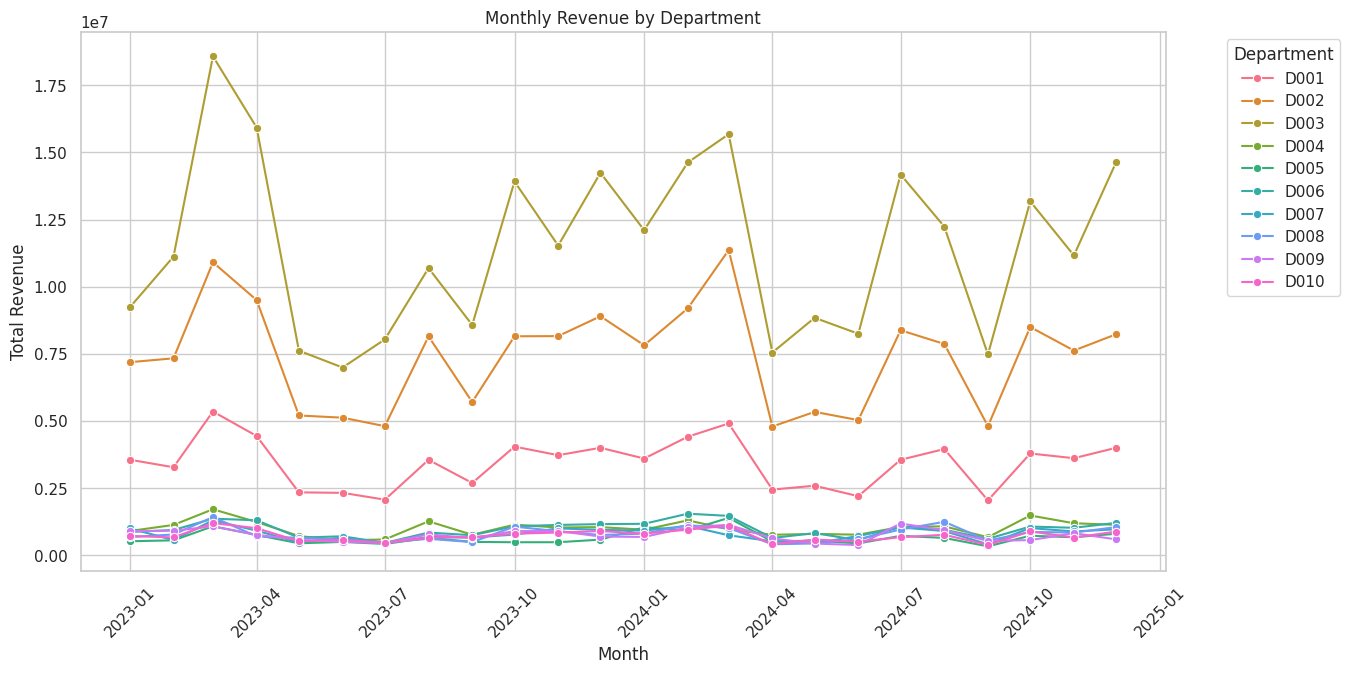

In [23]:
# Ensure transaction_date is in datetime
master['transaction_date'] = pd.to_datetime(master['transaction_date'], errors='coerce')

# Extract Year-Month
master['year_month'] = master['transaction_date'].dt.to_period('M').dt.to_timestamp()

# Revenue per department per month
dept_revenue = (
    master.groupby(['year_month','dept_id'])['total_cost']
    .sum()
    .reset_index()
)

# Plot revenue trends for each department
plt.figure(figsize=(14,7))
sns.lineplot(data=dept_revenue, x='year_month', y='total_cost', hue='dept_id', marker='o')
plt.title('Monthly Revenue by Department')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Sub-Category of drugs

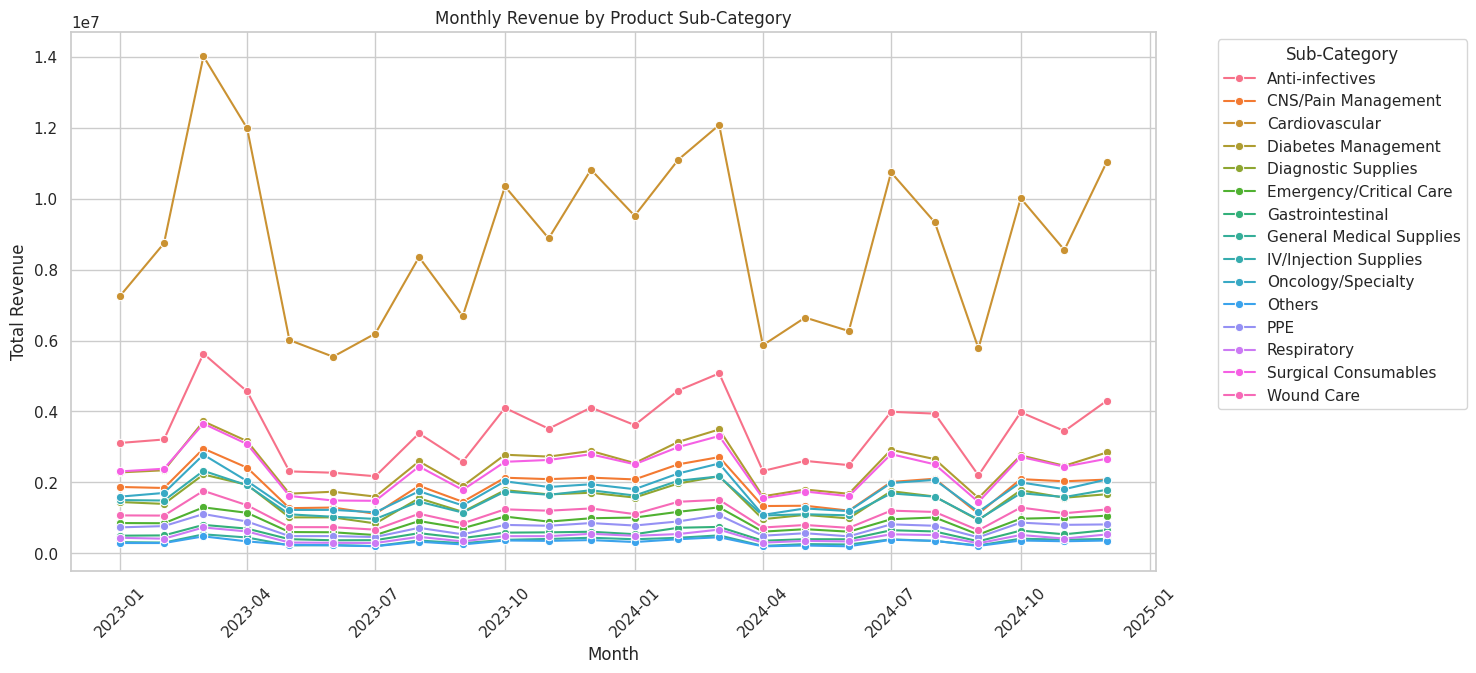

In [24]:
# Ensure transaction_date is datetime
master['transaction_date'] = pd.to_datetime(master['transaction_date'], errors='coerce')

# Extract Year-Month
master['year_month'] = master['transaction_date'].dt.to_period('M').dt.to_timestamp()

# Revenue per sub-category per month
if 'sku_sub_category' in master.columns:
    subcat_revenue = (
        master.groupby(['year_month','sku_sub_category'])['total_cost']
        .sum()
        .reset_index()
    )

    # Plot revenue trends for each sub-category
    plt.figure(figsize=(14,7))
    sns.lineplot(data=subcat_revenue, x='year_month', y='total_cost', hue='sku_sub_category', marker='o')
    plt.title('Monthly Revenue by Product Sub-Category')
    plt.xlabel('Month')
    plt.ylabel('Total Revenue')
    plt.xticks(rotation=45)
    plt.legend(title='Sub-Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("⚠️ Column 'sku_sub_category' not found in master dataset. Please check SKU file column names.")

Find SKU's having different pattern

In [25]:
# Aggregate monthly revenue per SKU
sku_monthly = (
    master.groupby([master['transaction_date'].dt.to_period('M'), 'sku_id'])['total_cost']
    .sum()
    .reset_index()
)

# Pivot to have SKU as columns, months as rows
sku_pivot = sku_monthly.pivot(index='transaction_date', columns='sku_id', values='total_cost').fillna(0)

# Normalize each SKU series (divide by its max, avoid skew from scale)
sku_norm = sku_pivot.div(sku_pivot.max(axis=0).replace(0,1), axis=1)

# Compute correlation of each SKU with the "average pattern"
avg_pattern = sku_norm.mean(axis=1)
correlations = sku_norm.corrwith(avg_pattern)

# Flag SKUs with low correlation (different patterns)
outliers = correlations[correlations < 0.5].sort_values()   # threshold can be tuned
print("Number of SKUs with different patterns:", len(outliers))
display(outliers.head(20))

Number of SKUs with different patterns: 6


,0
sku_id,
SKU00580,0.441775
SKU00057,0.441879
SKU00773,0.458493
SKU00544,0.462988
SKU00509,0.467141
SKU00081,0.475645


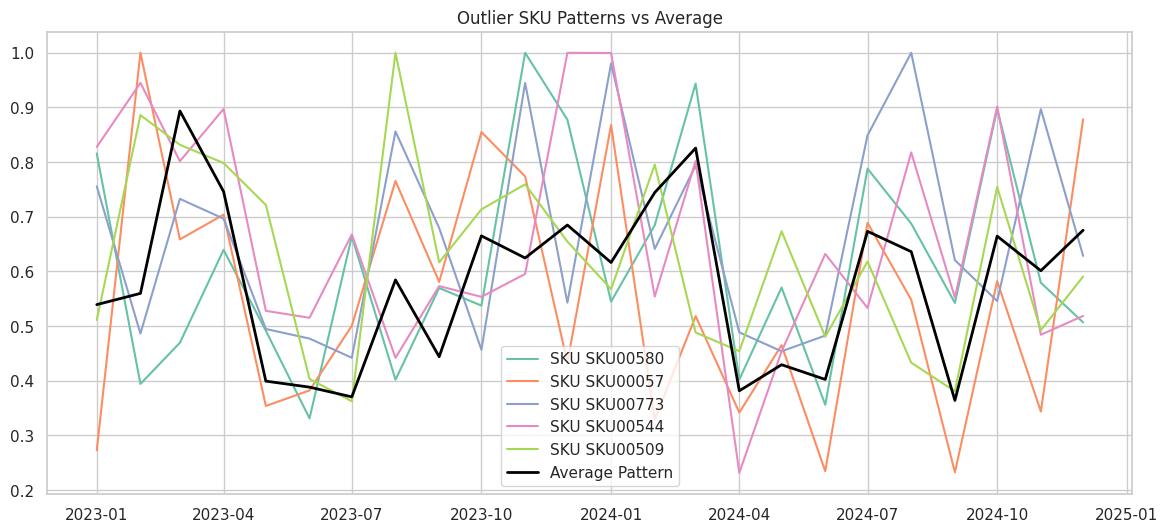

In [26]:
# Plot some "different pattern" SKUs vs the average
plt.figure(figsize=(14,6))
for sku in outliers.head(5).index:  # first 5 outliers
    plt.plot(sku_norm.index.to_timestamp(), sku_norm[sku], label=f'SKU {sku}')
plt.plot(sku_norm.index.to_timestamp(), avg_pattern, color='black', linewidth=2, label='Average Pattern')
plt.legend()
plt.title('Outlier SKU Patterns vs Average')
plt.show()


Clustering of SKu

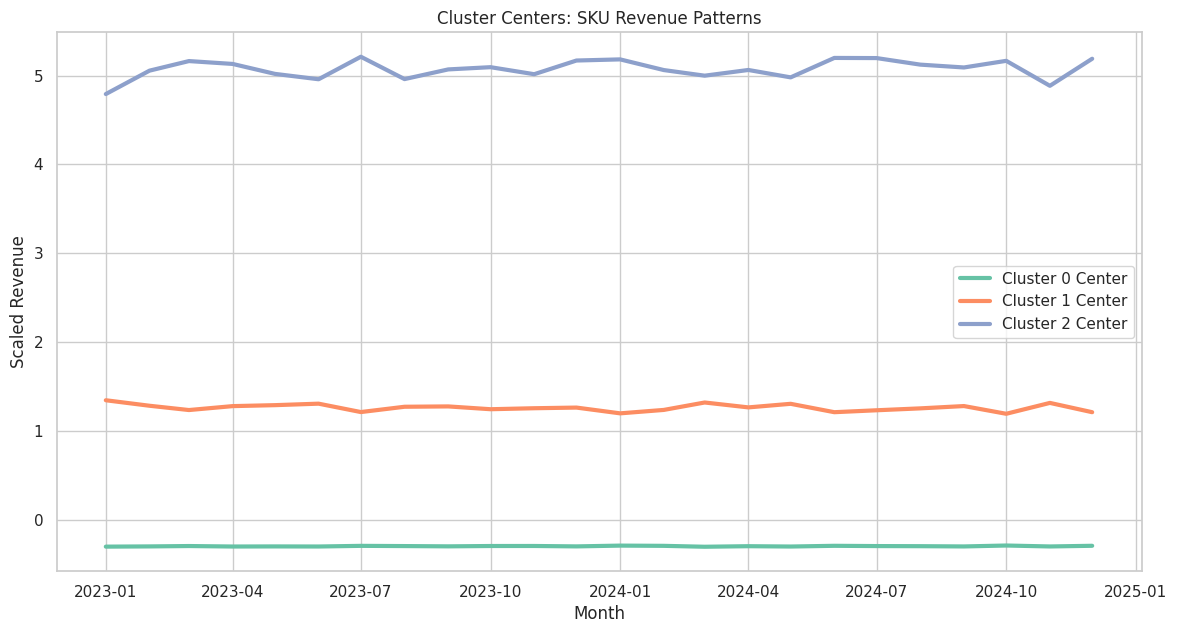

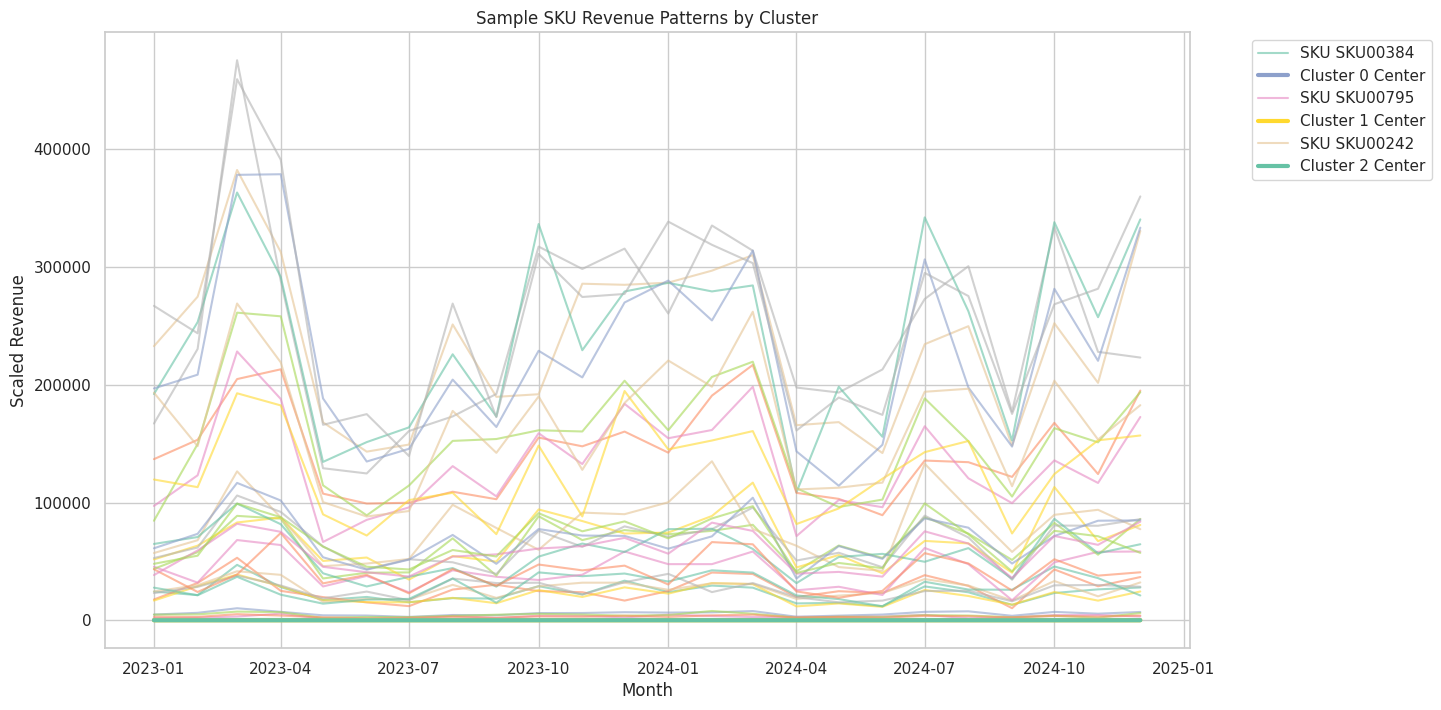

Number of SKUs per cluster:
cluster
0    1029
1     144
2      24
Name: count, dtype: int64


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Step 1: Aggregate monthly revenue per SKU ---
sku_monthly = (
    master.groupby([master['transaction_date'].dt.to_period('M'), 'sku_id'])['total_cost']
    .sum()
    .reset_index()
)

# --- Step 2: Pivot (rows=SKU, columns=months, values=revenue) ---
sku_pivot = sku_monthly.pivot(index='sku_id', columns='transaction_date', values='total_cost').fillna(0)

# Save time columns (months only)
time_cols = sku_pivot.columns
time_index = pd.PeriodIndex(time_cols, freq='M').to_timestamp()

# --- Step 3: Normalize (scale SKUs) ---
scaler = StandardScaler()
sku_scaled = scaler.fit_transform(sku_pivot)

# --- Step 4: KMeans clustering ---
k = 3  # adjust number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
sku_pivot['cluster'] = kmeans.fit_predict(sku_scaled)

# --- Step 5: Plot cluster centers ---
plt.figure(figsize=(14,7))
for cluster_id in range(k):
    center = kmeans.cluster_centers_[cluster_id][:len(time_cols)]
    plt.plot(time_index, center, label=f'Cluster {cluster_id} Center', linewidth=3)
plt.title('Cluster Centers: SKU Revenue Patterns')
plt.xlabel('Month')
plt.ylabel('Scaled Revenue')
plt.legend()
plt.show()

# --- Step 6: Plot sample SKUs per cluster ---
plt.figure(figsize=(14,8))
for cluster_id in range(k):
    sample_skus = sku_pivot[sku_pivot['cluster']==cluster_id].sample(
        min(10, (sku_pivot['cluster']==cluster_id).sum()), random_state=42
    ).index

    for sku in sample_skus:
        plt.plot(time_index, sku_pivot.loc[sku, time_cols], alpha=0.6,
                 label=f'SKU {sku}' if sku==sample_skus[0] else "")

    center = kmeans.cluster_centers_[cluster_id][:len(time_cols)]
    plt.plot(time_index, center, linewidth=3, label=f'Cluster {cluster_id} Center')

plt.title('Sample SKU Revenue Patterns by Cluster')
plt.xlabel('Month')
plt.ylabel('Scaled Revenue')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# --- Step 7: Cluster counts ---
cluster_counts = sku_pivot['cluster'].value_counts().sort_index()
print("Number of SKUs per cluster:")
print(cluster_counts)

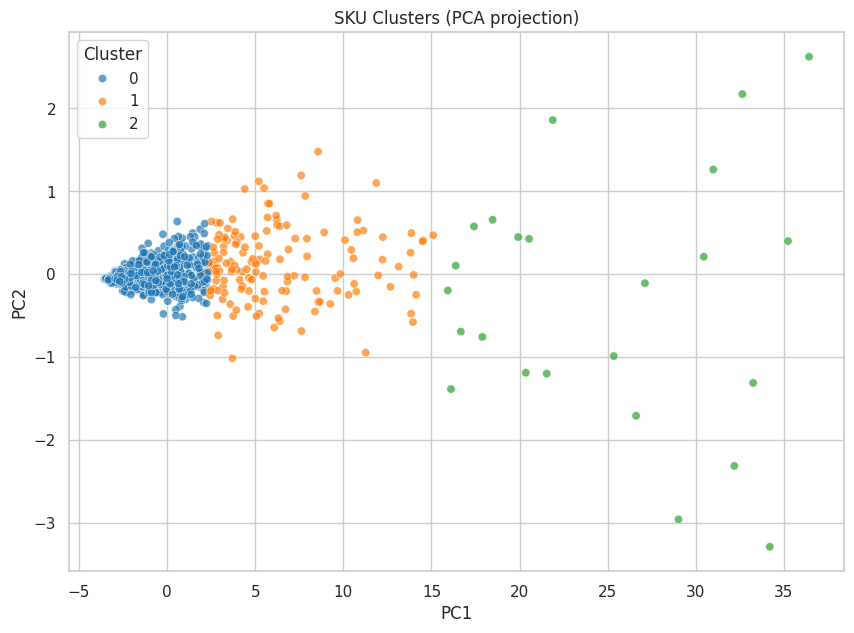

In [28]:
from sklearn.decomposition import PCA

# --- Step 1: Use the scaled time-series data (sku_scaled) ---
# Reduce to 2D with PCA
pca = PCA(n_components=2, random_state=42)
sku_pca = pca.fit_transform(sku_scaled)

# --- Step 2: Create a dataframe for plotting ---
sku_plot = pd.DataFrame(sku_pca, columns=['PC1','PC2'], index=sku_pivot.index)
sku_plot['cluster'] = sku_pivot['cluster']

# --- Step 3: Scatter plot ---
plt.figure(figsize=(10,7))
sns.scatterplot(data=sku_plot, x='PC1', y='PC2', hue='cluster', palette='tab10', alpha=0.7)
plt.title('SKU Clusters (PCA projection)')
plt.legend(title='Cluster')
plt.show()

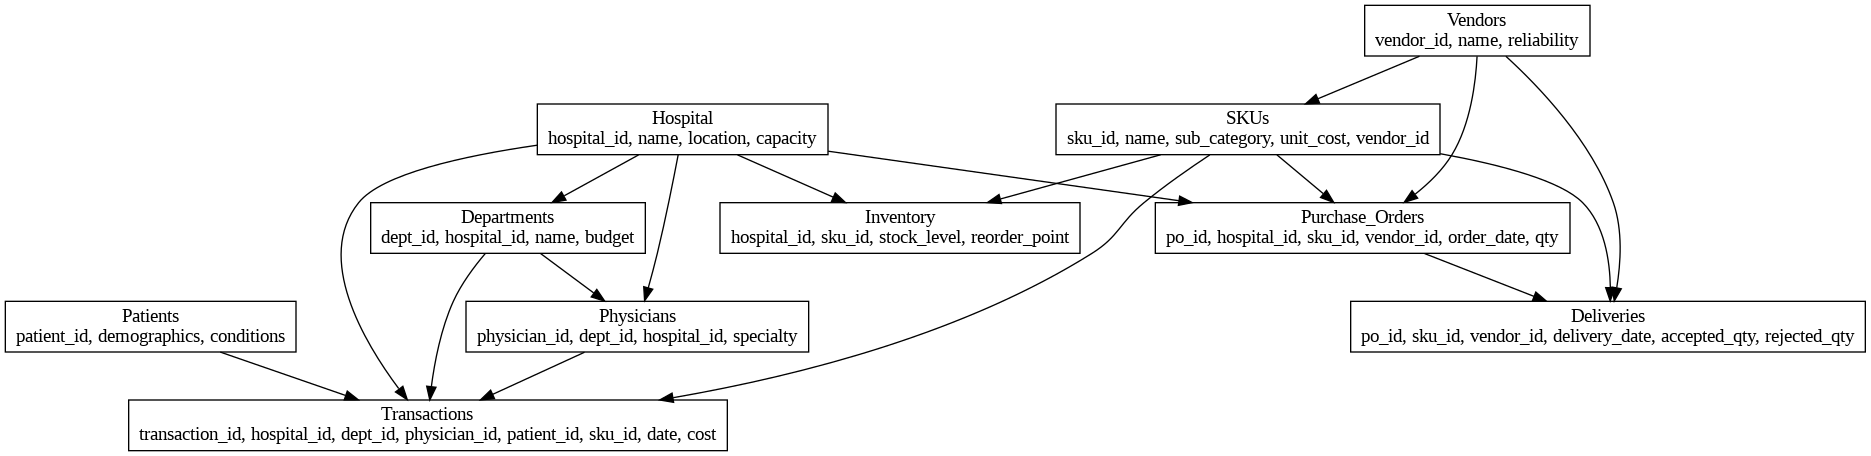

In [29]:
from graphviz import Digraph
from IPython.display import Image

dot = Digraph(comment="Hospital Dataset ER Diagram")

# Entities with attributes
entities = {
    "Hospital": "hospital_id, name, location, capacity",
    "Departments": "dept_id, hospital_id, name, budget",
    "Physicians": "physician_id, dept_id, hospital_id, specialty",
    "Patients": "patient_id, demographics, conditions",
    "Transactions": "transaction_id, hospital_id, dept_id, physician_id, patient_id, sku_id, date, cost",
    "SKUs": "sku_id, name, sub_category, unit_cost, vendor_id",
    "Vendors": "vendor_id, name, reliability",
    "Inventory": "hospital_id, sku_id, stock_level, reorder_point",
    "Purchase_Orders": "po_id, hospital_id, sku_id, vendor_id, order_date, qty",
    "Deliveries": "po_id, sku_id, vendor_id, delivery_date, accepted_qty, rejected_qty"
}

for ent, attrs in entities.items():
    dot.node(ent, f"{ent}\n{attrs}", shape="box")

# Relationships
dot.edge("Hospital", "Departments")
dot.edge("Hospital", "Physicians")
dot.edge("Hospital", "Transactions")
dot.edge("Hospital", "Inventory")
dot.edge("Hospital", "Purchase_Orders")

dot.edge("Departments", "Physicians")
dot.edge("Departments", "Transactions")

dot.edge("Physicians", "Transactions")
dot.edge("Patients", "Transactions")
dot.edge("SKUs", "Transactions")

dot.edge("SKUs", "Inventory")
dot.edge("SKUs", "Purchase_Orders")
dot.edge("SKUs", "Deliveries")

dot.edge("Vendors", "SKUs")
dot.edge("Vendors", "Purchase_Orders")
dot.edge("Vendors", "Deliveries")

dot.edge("Purchase_Orders", "Deliveries")

# Render in memory and display directly
img_bytes = dot.pipe(format="png")
Image(img_bytes)

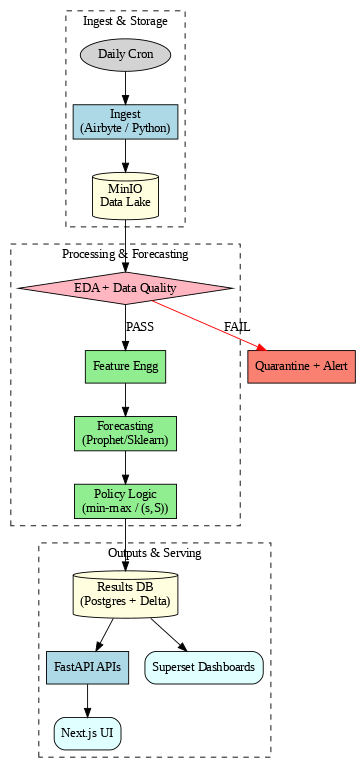

In [30]:
from graphviz import Digraph
from IPython.display import Image

# Vertical grouped architecture
dot_vg = Digraph(comment="Vertical Grouped Architecture", format="png")
dot_vg.attr(rankdir="TB", size="8")

# Ingest & Storage
with dot_vg.subgraph(name="cluster_ingest") as c:
    c.attr(label="Ingest & Storage", style="dashed")
    c.node("cron", "Daily Cron", shape="oval", style="filled", fillcolor="lightgrey")
    c.node("ingest", "Ingest\n(Airbyte / Python)", shape="box", style="filled", fillcolor="lightblue")
    c.node("minio", "MinIO\nData Lake", shape="cylinder", style="filled", fillcolor="lightyellow")
    c.edge("cron","ingest")
    c.edge("ingest","minio")

# Processing
with dot_vg.subgraph(name="cluster_process") as c:
    c.attr(label="Processing & Forecasting", style="dashed")
    c.node("eda", "EDA + Data Quality", shape="diamond", style="filled", fillcolor="lightpink")
    c.node("features", "Feature Engg", shape="box", style="filled", fillcolor="lightgreen")
    c.node("forecast", "Forecasting\n(Prophet/Sklearn)", shape="box", style="filled", fillcolor="lightgreen")
    c.node("policy", "Policy Logic\n(min-max / (s,S))", shape="box", style="filled", fillcolor="lightgreen")
    c.edge("minio","eda")
    c.edge("eda","features", label="PASS")
    c.edge("features","forecast")
    c.edge("forecast","policy")

# Outputs
with dot_vg.subgraph(name="cluster_output") as c:
    c.attr(label="Outputs & Serving", style="dashed")
    c.node("results", "Results DB\n(Postgres + Delta)", shape="cylinder", style="filled", fillcolor="lightyellow")
    c.node("fastapi", "FastAPI APIs", shape="box", style="filled", fillcolor="lightblue")
    c.node("nextjs", "Next.js UI", shape="rect", style="rounded,filled", fillcolor="lightcyan")
    c.node("superset", "Superset Dashboards", shape="rect", style="rounded,filled", fillcolor="lightcyan")
    c.edge("policy","results")
    c.edge("results","fastapi")
    c.edge("results","superset")
    c.edge("fastapi","nextjs")

# Quarantine branch
dot_vg.node("quarantine", "Quarantine + Alert", shape="box", style="filled", fillcolor="salmon")
dot_vg.edge("eda","quarantine", label="FAIL", color="red")

# Render
img_bytes_vg = dot_vg.pipe(format="png")
Image(img_bytes_vg)


SKU seeing drop significantly

In [31]:
# Ensure transaction_date is datetime
master['transaction_date'] = pd.to_datetime(master['transaction_date'], errors='coerce')

# Extract year
master['year'] = master['transaction_date'].dt.year

# Aggregate sales per SKU per year
sku_year_sales = (
    master.groupby(['sku_id','year'])['total_cost']
    .sum()
    .reset_index()
)

# Pivot to get 2023 vs 2024 side by side
sku_pivot = sku_year_sales.pivot(index='sku_id', columns='year', values='total_cost').fillna(0)
sku_pivot = sku_pivot.rename(columns={2023:'sales_2023', 2024:'sales_2024'})

# Calculate drop
sku_pivot['change'] = sku_pivot['sales_2024'] - sku_pivot['sales_2023']
sku_pivot['pct_change'] = (sku_pivot['change'] / sku_pivot['sales_2023'].replace(0, np.nan)) * 100

# Reset index to merge with SKU metadata
sku_pivot = sku_pivot.reset_index()

# Merge with SKU table to get SKU names
if 'sku_sku_name' in master.columns:   # adjust if column name is different
    sku_pivot = sku_pivot.merge(master[['sku_id','sku_sku_name']].drop_duplicates(), on='sku_id', how='left')

# Filter only declining SKUs
dropped_skus = sku_pivot[sku_pivot['change'] < 0].sort_values('pct_change')

print("Top SKUs with biggest drop in sales from 2023 → 2024:")
display(dropped_skus[['sku_id','sku_sku_name','sales_2023','sales_2024','change','pct_change']].head(20))

Top SKUs with biggest drop in sales from 2023 → 2024:


,sku_id,sku_sku_name,sales_2023,sales_2024,change,pct_change
816,SKU00817,Surgical Masks - Small,163404.40,120368.10,-43036.30,-26.337296
780,SKU00781,Surgical Gloves - Small,282880.80,216342.00,-66538.80,-23.521851
89,SKU00090,Sitagliptin 100mg Tablet (Generic),79995.00,62585.37,-17409.63,-21.763398
113,SKU00114,Insulin Glargine 10mg Tablet (Brand),283639.14,222385.68,-61253.46,-21.595560
898,SKU00899,Surgical Gloves - Medium,364499.44,288140.56,-76358.88,-20.948970
862,SKU00863,Surgical Drapes - XL,135700.95,107617.05,-28083.90,-20.695434
536,SKU00537,Budesonide 250mg Cream (Generic),6940.33,5599.26,-1341.07,-19.322856
533,SKU00534,Salbutamol 25mg Cream (Brand),70717.24,57169.72,-13547.52,-19.157309
1077,SKU01078,Bandages - XL,194481.56,157477.32,-37004.24,-19.027120
1189,SKU01190,Stethoscopes - Large,82441.76,67046.44,-15395.32,-18.674177


In [32]:
!pip install ace_tools

Department Wise Analysis

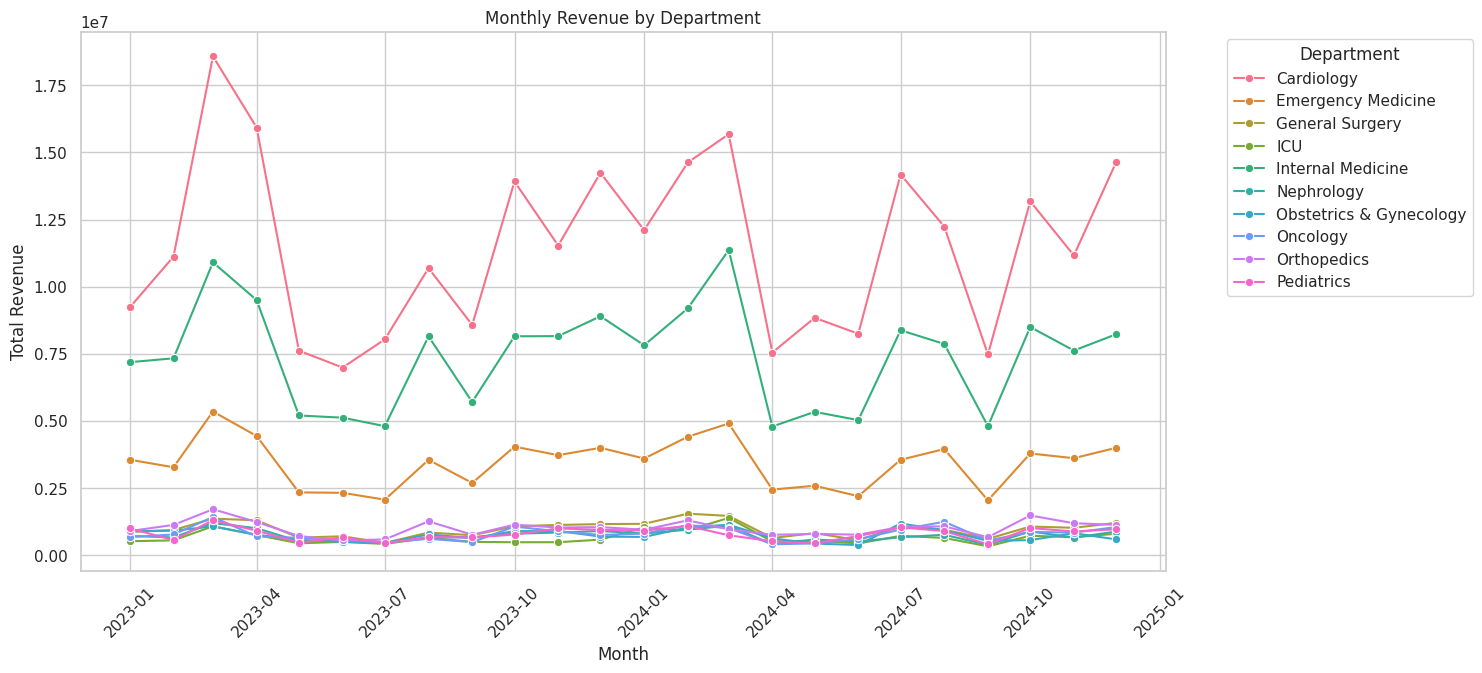

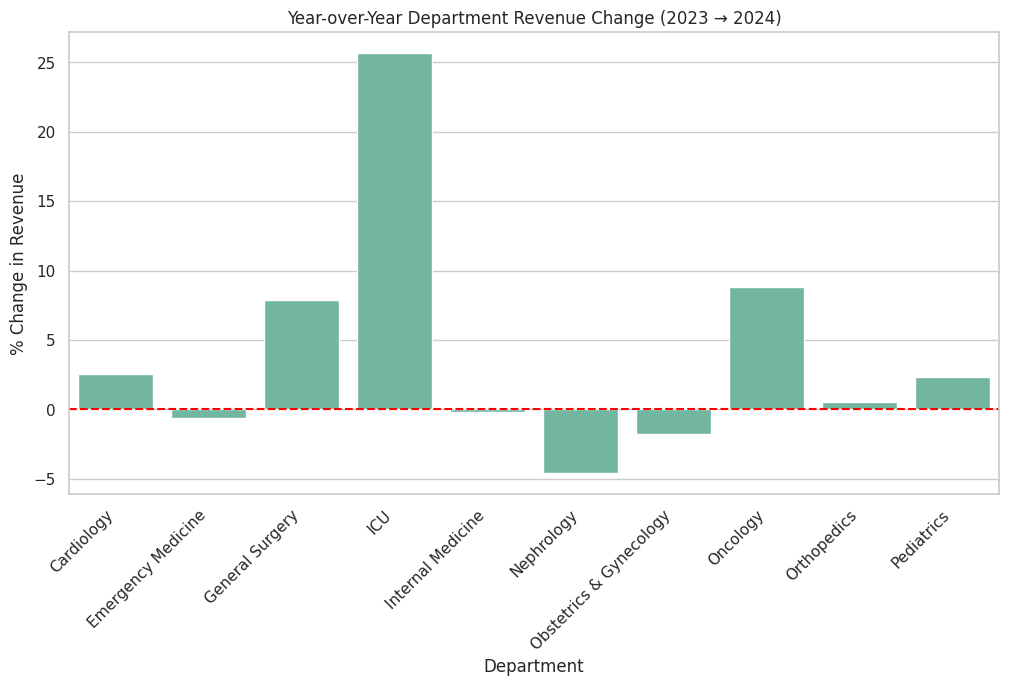

,dept_dept_name,revenue,transactions,avg_transaction_value,patients,physicians,adherence_rate,bounce_rate
0,Cardiology,2.764244e+08,1021862,270.510456,12209,13,0.556422,0.135565
1,Emergency Medicine,8.246845e+07,392620,210.046477,16732,9,0.447468,0.025241
2,General Surgery,2.335285e+07,77226,302.396249,1732,12,0.706731,0.078562
3,ICU,1.567981e+07,82982,188.954366,1783,8,0.548962,0.091755
4,Internal Medicine,1.780867e+08,659924,269.859343,8794,9,0.692155,0.120437
5,Nephrology,1.759761e+07,77055,228.377234,1701,15,0.717760,0.071170
6,Obstetrics & Gynecology,1.795908e+07,77675,231.207955,1712,14,0.692050,0.104500
7,Oncology,1.895049e+07,81510,232.492815,1816,15,0.623212,0.096933
8,Orthopedics,2.418245e+07,80635,299.900121,1763,11,0.687791,0.098444
9,Pediatrics,1.902441e+07,82467,230.691202,1758,14,0.682770,0.139353


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Department Summary with dept_dept_name ---
dept_summary = master.groupby('dept_dept_name').agg(
    revenue=('total_cost','sum'),
    transactions=('transaction_id','count'),
    avg_transaction_value=('total_cost','mean'),
    patients=('patient_id','nunique'),
    physicians=('physician_id','nunique')
).reset_index()

# Add adherence & bounce if available
if 'formulary_adherent' in master.columns:
    adherence = master.groupby('dept_dept_name')['formulary_adherent'].mean().reset_index().rename(columns={'formulary_adherent':'adherence_rate'})
    dept_summary = dept_summary.merge(adherence, on='dept_dept_name', how='left')

if 'bounced' in master.columns:
    bounce = master.groupby('dept_dept_name')['bounced'].mean().reset_index().rename(columns={'bounced':'bounce_rate'})
    dept_summary = dept_summary.merge(bounce, on='dept_dept_name', how='left')

# --- Monthly Revenue Trends ---
dept_trends = (
    master.groupby(['year_month','dept_dept_name'])['total_cost']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14,7))
sns.lineplot(data=dept_trends, x='year_month', y='total_cost', hue='dept_dept_name', marker='o')
plt.title("Monthly Revenue by Department")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.legend(title="Department", bbox_to_anchor=(1.05,1))
plt.show()

# --- Top SKUs per department ---
top_skus = (
    master.groupby(['dept_dept_name','sku_id'])['total_cost']
    .sum()
    .reset_index()
    .sort_values(['dept_dept_name','total_cost'], ascending=[True,False])
)
top_skus = top_skus.groupby('dept_dept_name').head(5)

# --- Yearly Department Revenue Comparison (2023 vs 2024) ---
dept_yearly = (
    master.groupby(['dept_dept_name','year'])['total_cost']
    .sum()
    .reset_index()
    .pivot(index='dept_dept_name', columns='year', values='total_cost')
    .fillna(0)
    .reset_index()
)

if 2023 in dept_yearly.columns and 2024 in dept_yearly.columns:
    dept_yearly['change'] = dept_yearly[2024] - dept_yearly[2023]
    dept_yearly['pct_change'] = (dept_yearly['change'] / dept_yearly[2023].replace(0, pd.NA)) * 100

    plt.figure(figsize=(12,6))
    sns.barplot(data=dept_yearly, x='dept_dept_name', y='pct_change')
    plt.title("Year-over-Year Department Revenue Change (2023 → 2024)")
    plt.xlabel("Department")
    plt.ylabel("% Change in Revenue")
    plt.axhline(0, color='red', linestyle='--')
    plt.xticks(rotation=45, ha="right")
    plt.show()

# --- Show Department Summary ---
display(dept_summary)


Physican wise Analysis

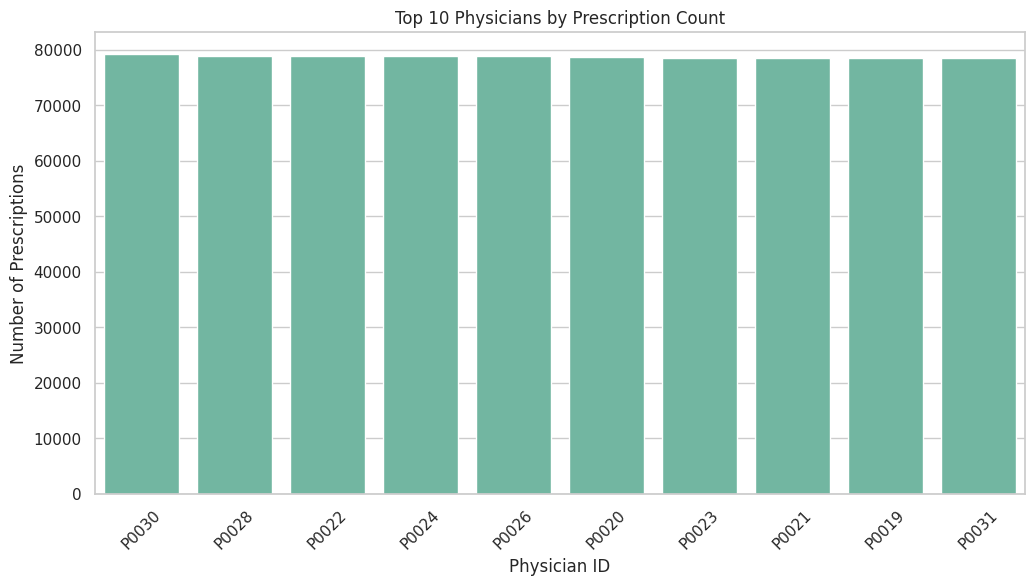

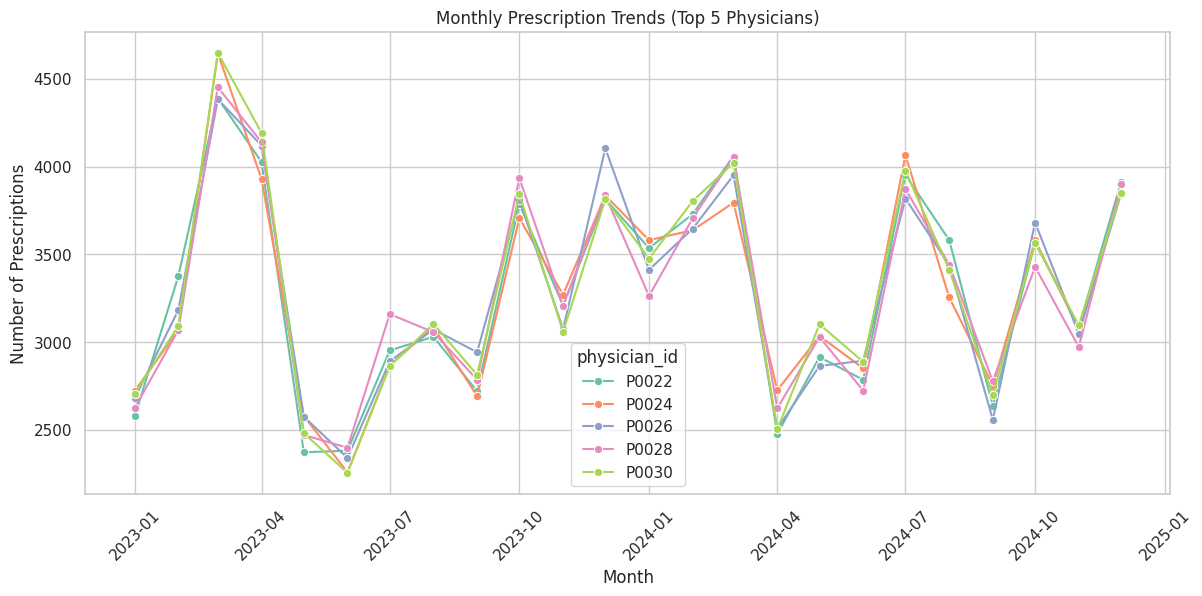

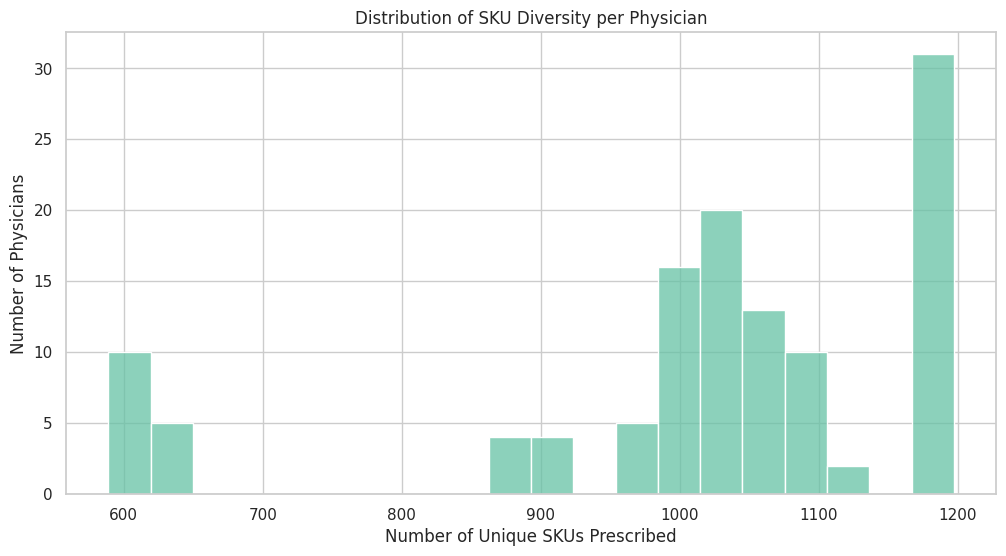

,physician_id,prescriptions,revenue,avg_transaction_value,patients,unique_skus,adherence_rate,bounce_rate
0,P0001,44087,9216909.77,209.061850,10494,1190,0.523896,0.023363
1,P0002,43349,9256989.45,213.545629,10347,1183,0.415188,0.023922
2,P0003,43947,9143403.42,208.055235,10443,1181,0.407582,0.026600
3,P0004,43716,9082676.49,207.765498,10374,1189,0.442058,0.026443
4,P0005,43309,9048955.13,208.939369,10287,1191,0.489667,0.024660
5,P0006,43782,9219157.91,210.569593,10303,1187,0.443424,0.024234
6,P0007,43012,9034154.35,210.037998,10240,1184,0.463150,0.025481
7,P0008,43571,9209727.75,211.372880,10334,1184,0.413279,0.025889
8,P0009,43847,9256473.52,211.108480,10439,1187,0.428855,0.026570
9,P0010,73295,19937813.12,272.021463,6028,1197,0.678205,0.119108


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Physician Summary ---
phys_summary = master.groupby('physician_id').agg(
    prescriptions=('transaction_id','count'),
    revenue=('total_cost','sum'),
    avg_transaction_value=('total_cost','mean'),
    patients=('patient_id','nunique'),
    unique_skus=('sku_id','nunique')
).reset_index()

# Add adherence & bounce
if 'formulary_adherent' in master.columns:
    adherence = master.groupby('physician_id')['formulary_adherent'].mean().reset_index().rename(columns={'formulary_adherent':'adherence_rate'})
    phys_summary = phys_summary.merge(adherence, on='physician_id', how='left')

if 'bounced' in master.columns:
    bounce = master.groupby('physician_id')['bounced'].mean().reset_index().rename(columns={'bounced':'bounce_rate'})
    phys_summary = phys_summary.merge(bounce, on='physician_id', how='left')

# --- 2. Top Physicians by Prescriptions ---
top_phys = phys_summary.sort_values('prescriptions', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_phys, x='physician_id', y='prescriptions')
plt.title("Top 10 Physicians by Prescription Count")
plt.xlabel("Physician ID")
plt.ylabel("Number of Prescriptions")
plt.xticks(rotation=45)
plt.show()

# --- 3. Monthly Prescription Trends for Top 5 Physicians ---
top5_ids = top_phys['physician_id'].head(5).tolist()

phys_trends = (
    master[master['physician_id'].isin(top5_ids)]
    .groupby([master['transaction_date'].dt.to_period('M'), 'physician_id'])['transaction_id']
    .count()
    .reset_index()
)

phys_trends['transaction_date'] = phys_trends['transaction_date'].dt.to_timestamp()

plt.figure(figsize=(14,6))
sns.lineplot(data=phys_trends, x='transaction_date', y='transaction_id', hue='physician_id', marker='o')
plt.title("Monthly Prescription Trends (Top 5 Physicians)")
plt.xlabel("Month")
plt.ylabel("Number of Prescriptions")
plt.xticks(rotation=45)
plt.show()

# --- 4. Physician Diversity (number of SKUs prescribed) ---
plt.figure(figsize=(12,6))
sns.histplot(phys_summary['unique_skus'], bins=20, kde=False)
plt.title("Distribution of SKU Diversity per Physician")
plt.xlabel("Number of Unique SKUs Prescribed")
plt.ylabel("Number of Physicians")
plt.show()

# --- Show Physician Summary Table ---
display(phys_summary.head(20))


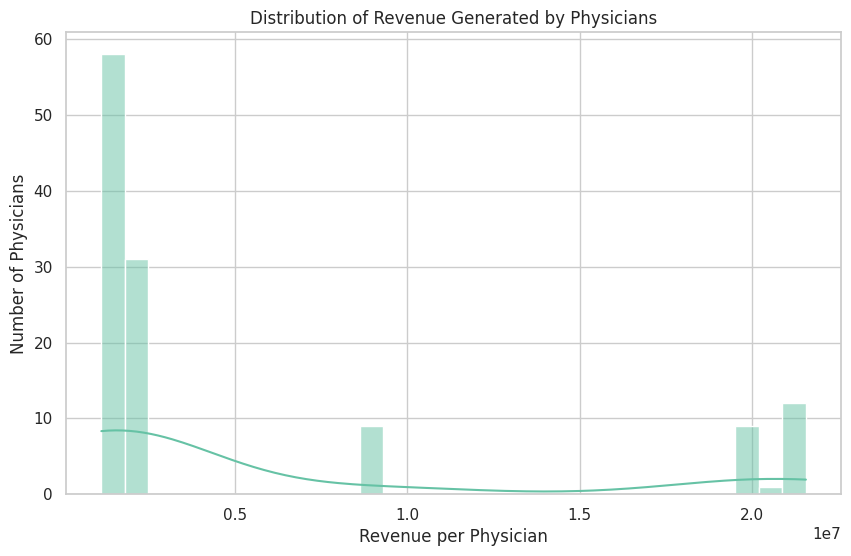

In [35]:
# Aggregate revenue per physician
phys_revenue = master.groupby('physician_id')['total_cost'].sum().reset_index().rename(columns={'total_cost':'revenue'})

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(phys_revenue['revenue'], bins=30, kde=True)
plt.title("Distribution of Revenue Generated by Physicians")
plt.xlabel("Revenue per Physician")
plt.ylabel("Number of Physicians")
plt.show()

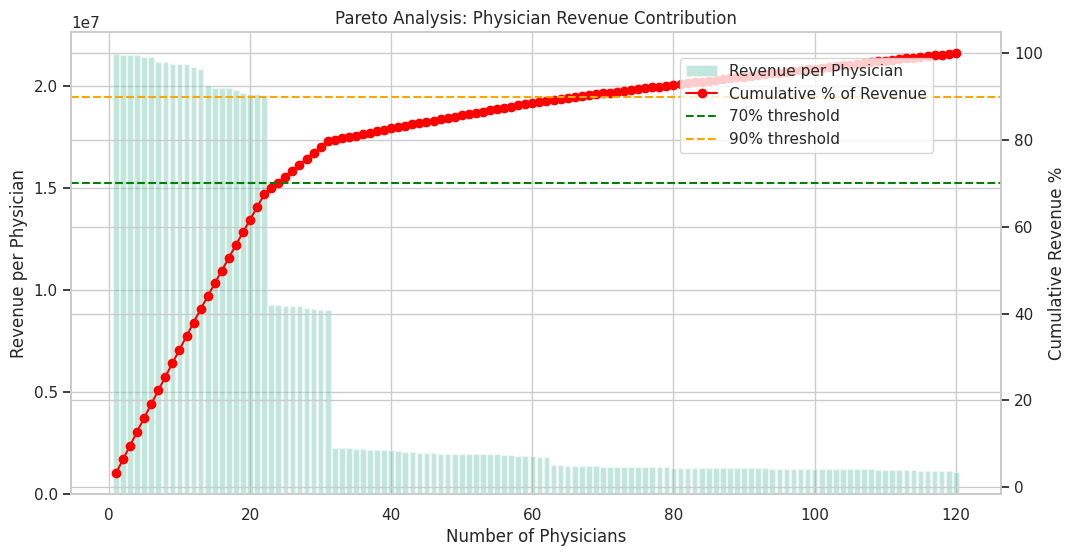

In [36]:
# Sort physicians by revenue
phys_revenue = phys_revenue.sort_values('revenue', ascending=False).reset_index(drop=True)

# Cumulative % of physicians
phys_revenue['phys_rank'] = range(1, len(phys_revenue)+1)
phys_revenue['phys_pct'] = phys_revenue['phys_rank'] / len(phys_revenue) * 100

# Cumulative % of revenue
phys_revenue['cum_revenue_pct'] = phys_revenue['revenue'].cumsum() / phys_revenue['revenue'].sum() * 100

# Plot Pareto curve
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()

ax1.bar(phys_revenue['phys_rank'], phys_revenue['revenue'], alpha=0.4, label="Revenue per Physician")
ax2.plot(phys_revenue['phys_rank'], phys_revenue['cum_revenue_pct'], color='red', marker='o', label="Cumulative % of Revenue")

ax1.set_xlabel("Number of Physicians")
ax1.set_ylabel("Revenue per Physician")
ax2.set_ylabel("Cumulative Revenue %")

ax2.axhline(70, color='green', linestyle='--', label='70% threshold')
ax2.axhline(90, color='orange', linestyle='--', label='90% threshold')

fig.legend(loc="upper right", bbox_to_anchor=(0.85,0.85))
plt.title("Pareto Analysis: Physician Revenue Contribution")
plt.show()

In [37]:
# --- Step 1: Find Top 10 Physicians by Revenue ---
top10_phys = (
    master.groupby('physician_id')['total_cost']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# --- Step 2: Filter transactions for these physicians ---
top_phys_data = master[master['physician_id'].isin(top10_phys)]

# --- Step 3: Aggregate medicine usage per physician ---
phys_sku = (
    top_phys_data.groupby(['physician_id','sku_id'])
    .agg(
        prescriptions=('transaction_id','count'),
        quantity=('quantity_consumed','sum'),
        revenue=('total_cost','sum')
    )
    .reset_index()
)

# --- Step 4: Add medicine details from SKU metadata ---
if 'sku_description' in master.columns:
    sku_details = master[['sku_id','sku_description','sku_sub_category','unit_cost']].drop_duplicates()
else:
    sku_cols = [c for c in master.columns if 'sku' in c.lower()]
    print("Available SKU columns:", sku_cols)
    sku_details = master[sku_cols].drop_duplicates()

phys_sku = phys_sku.merge(sku_details, on='sku_id', how='left')

# --- Step 5: Get Top Medicines per Doctor (Top 5) ---
top_meds_per_phys = phys_sku.sort_values(['physician_id','revenue'], ascending=[True,False]).groupby('physician_id').head(5)

# Display
from IPython.display import display
display(top_meds_per_phys.head(50))  # Show top 50 rows (5 meds x 10 doctors)

Available SKU columns: ['sku_id', 'sku_sku_name', 'sku_category', 'sku_sub_category', 'sku_therapeutic_area', 'sku_brand_generic_flag', 'sku_unit_of_measure', 'sku_standard_cost', 'sku_shelf_life_days', 'sku_storage_requirements', 'sku_controlled_substance_flag', 'sku_halal_certified', 'sku_base_drug_name', 'sku_consumption_volatility', 'sku_criticality_level', 'sku_formulary_status', 'sku_price_sensitivity']


,physician_id,sku_id,prescriptions,quantity,revenue,sku_sku_name,sku_category,sku_sub_category,sku_therapeutic_area,sku_brand_generic_flag,sku_unit_of_measure,sku_standard_cost,sku_shelf_life_days,sku_storage_requirements,sku_controlled_substance_flag,sku_halal_certified,sku_base_drug_name,sku_consumption_volatility,sku_criticality_level,sku_formulary_status,sku_price_sensitivity
255,P0019,SKU00256,460,2325.64,408345.28,Atorvastatin 10mg Tablet (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,147.17,1436,Freezer,False,True,Atorvastatin,0.12,High,Restricted,0.281473
175,P0019,SKU00176,315,1585.74,380352.90,Atorvastatin 25mg Capsule (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,203.06,1018,Freezer,False,True,Atorvastatin,0.12,High,Restricted,0.672868
261,P0019,SKU00262,200,1039.10,345709.26,Atorvastatin 500mg Cream (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,284.48,506,Refrigerated,False,True,Atorvastatin,0.12,High,Non-Preferred,0.329111
241,P0019,SKU00242,288,1484.91,334745.37,Amlodipine 250mg Injection (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,196.52,1244,Freezer,False,True,Amlodipine,0.12,High,Preferred,0.100760
231,P0019,SKU00232,264,1342.86,329318.10,Amlodipine 250mg Cream (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,214.88,1614,Freezer,False,True,Amlodipine,0.12,High,Restricted,0.197464
1426,P0020,SKU00232,327,1476.90,366896.94,Amlodipine 250mg Cream (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,214.88,1614,Freezer,False,True,Amlodipine,0.12,High,Restricted,0.197464
1370,P0020,SKU00176,294,1545.30,366221.34,Atorvastatin 25mg Capsule (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,203.06,1018,Freezer,False,True,Atorvastatin,0.12,High,Restricted,0.672868
1436,P0020,SKU00242,321,1598.94,352149.21,Amlodipine 250mg Injection (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,196.52,1244,Freezer,False,True,Amlodipine,0.12,High,Preferred,0.100760
1456,P0020,SKU00262,206,1057.68,339827.64,Atorvastatin 500mg Cream (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,284.48,506,Refrigerated,False,True,Atorvastatin,0.12,High,Non-Preferred,0.329111
1497,P0020,SKU00303,328,1826.56,323564.84,Amlodipine 500mg Syrup (Brand),Pharmacy,Cardiovascular,Cardiovascular,Brand,Pack,153.07,798,Room_Temp,False,True,Amlodipine,0.12,High,Non-Preferred,0.154858


Vendor vs Purchaseorders taken and delivered and their respective delays - insights

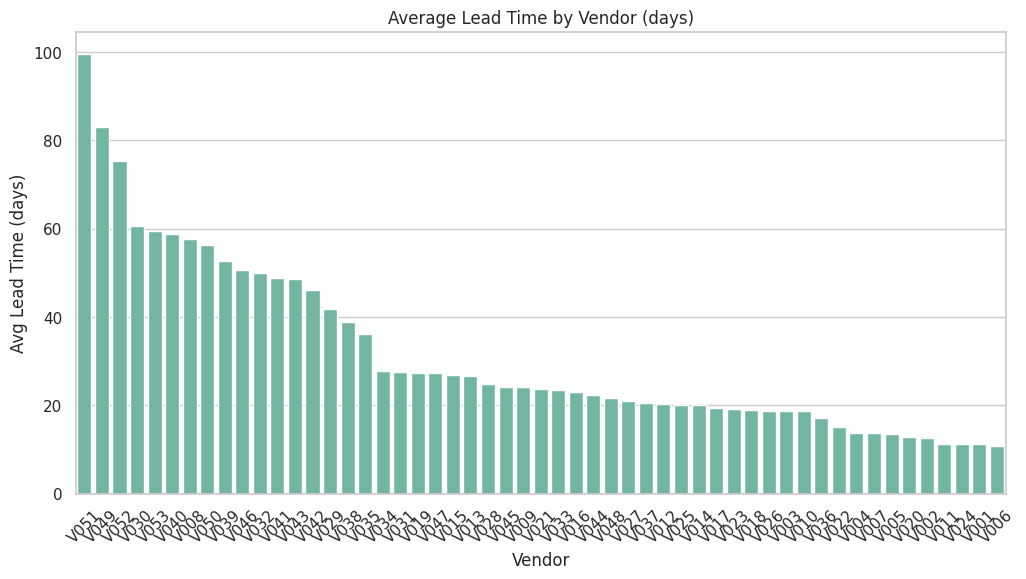

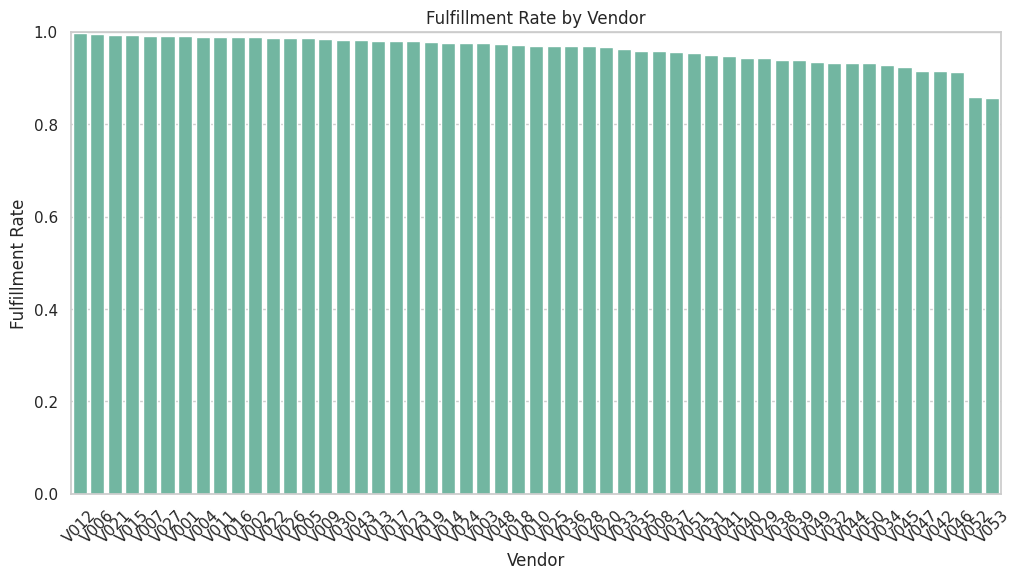

,vendor_id,total_pos,total_ordered,total_delivered,avg_lead_time,on_time_rate,fulfillment_rate
0,V001,1658,764148.83,756700.38,11.219542,0.271411,0.990253
1,V002,652,337681.58,333536.12,12.671779,0.237730,0.987724
2,V003,693,329155.22,320849.96,18.770563,0.152958,0.974768
3,V004,1279,597059.92,590656.26,13.730258,0.251759,0.989275
4,V005,214,98117.48,96791.45,13.434579,0.093458,0.986485
5,V006,1153,479083.25,476931.04,10.737207,0.351258,0.995508
6,V007,77,20412.07,20244.17,13.701299,0.376623,0.991774
7,V008,626,301971.42,289116.76,57.570288,0.119808,0.957431
8,V009,306,168310.05,165500.43,24.215686,0.058824,0.983307
9,V010,322,145130.14,140774.00,18.698758,0.121118,0.969985


In [38]:
# --- Step 1: Merge Purchase Orders and Deliveries ---
common_keys = [k for k in ['po_id','sku_id','vendor_id'] if k in df_pos.columns and k in df_deliveries.columns]
scm = pd.merge(df_pos, df_deliveries, on=common_keys, how='left', suffixes=('_po','_dlv'))

# --- Step 2: Calculate lead times and delays ---
if 'delivery_date' in scm.columns and 'po_date' in scm.columns:
    scm['lead_time_days'] = (scm['delivery_date'] - scm['po_date']).dt.days

if 'delivery_date' in scm.columns and 'requested_delivery_date' in scm.columns:
    scm['on_time'] = (scm['delivery_date'] <= scm['requested_delivery_date'])

# --- Step 3: Vendor-level Aggregation ---
vendor_perf = scm.groupby('vendor_id').agg(
    total_pos=('po_id','nunique'),
    total_ordered=('ordered_quantity','sum'),
    total_delivered=('accepted_quantity','sum'),
    avg_lead_time=('lead_time_days','mean'),
    on_time_rate=('on_time', lambda x: np.nan if x.isna().all() else x.mean())
).reset_index()

# Calculate fulfillment rate
vendor_perf['fulfillment_rate'] = vendor_perf['total_delivered'] / vendor_perf['total_ordered']

# --- Step 4: Visualize Lead Times ---
plt.figure(figsize=(12,6))
sns.barplot(data=vendor_perf.sort_values('avg_lead_time', ascending=False),
            x='vendor_id', y='avg_lead_time')
plt.title("Average Lead Time by Vendor (days)")
plt.xlabel("Vendor")
plt.ylabel("Avg Lead Time (days)")
plt.xticks(rotation=45)
plt.show()

# --- Step 5: Visualize Fulfillment Rate ---
plt.figure(figsize=(12,6))
sns.barplot(data=vendor_perf.sort_values('fulfillment_rate', ascending=False),
            x='vendor_id', y='fulfillment_rate')
plt.title("Fulfillment Rate by Vendor")
plt.xlabel("Vendor")
plt.ylabel("Fulfillment Rate")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

# --- Display Vendor Performance Table ---
from IPython.display import display
display(vendor_perf.head(20))


Margin Per product

In [39]:
# --- Step 1: Procurement price per SKU ---
# If unit_cost exists in deliveries
if 'actual_unit_price' in df_deliveries.columns:
    sku_procurement = (
        df_deliveries.groupby('sku_id')
        .apply(lambda x: (x['accepted_quantity'] * x['actual_unit_price']).sum() / x['accepted_quantity'].sum()
               if x['accepted_quantity'].sum() > 0 else np.nan)
        .reset_index(name='avg_procurement_price')
    )
else:
    print("⚠️ No unit_cost in deliveries. Please confirm procurement cost column.")

# --- Step 2: Selling price per SKU ---
sku_selling = (
    master.groupby('sku_id')
    .apply(lambda x: (x['total_cost'].sum() / x['quantity_consumed'].sum())
           if x['quantity_consumed'].sum() > 0 else np.nan)
    .reset_index(name='avg_selling_price')
)

# --- Step 3: Merge procurement and selling prices ---
sku_price_compare = sku_procurement.merge(sku_selling, on='sku_id', how='inner')

# --- Step 4: Add margin and flag negative cases ---
sku_price_compare['margin_per_unit'] = sku_price_compare['avg_selling_price'] - sku_price_compare['avg_procurement_price']
sku_price_compare['loss_flag'] = sku_price_compare['margin_per_unit'] < 0

# --- Step 5: Filter SKUs sold at a loss ---
loss_skus = sku_price_compare[sku_price_compare['loss_flag'] == True]

# Show SKUs with loss
from IPython.display import display
display(loss_skus.sort_values('margin_per_unit').head(20))

/tmp/ipython-input-1980856451.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['accepted_quantity'] * x['actual_unit_price']).sum() / x['accepted_quantity'].sum()
/tmp/ipython-input-1980856451.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['total_cost'].sum() / x['quantity_consumed'].sum())


,sku_id,avg_procurement_price,avg_selling_price,margin_per_unit,loss_flag
635,SKU00636,402.950049,274.247780,-128.702269,True
679,SKU00680,339.658394,227.124307,-112.534087,True
694,SKU00695,351.219501,241.731616,-109.487884,True
671,SKU00672,300.573636,199.162619,-101.411017,True
638,SKU00639,314.680261,224.752519,-89.927741,True
630,SKU00631,295.440940,211.515108,-83.925832,True
697,SKU00698,298.675851,218.770199,-79.905652,True
662,SKU00663,302.852340,224.824309,-78.028031,True
698,SKU00699,378.423885,301.765548,-76.658337,True
676,SKU00677,248.716364,172.574123,-76.142241,True


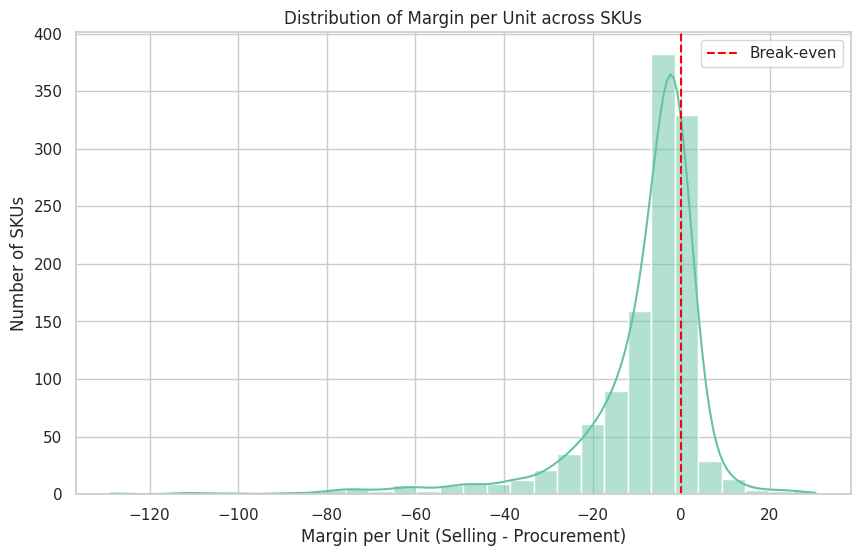

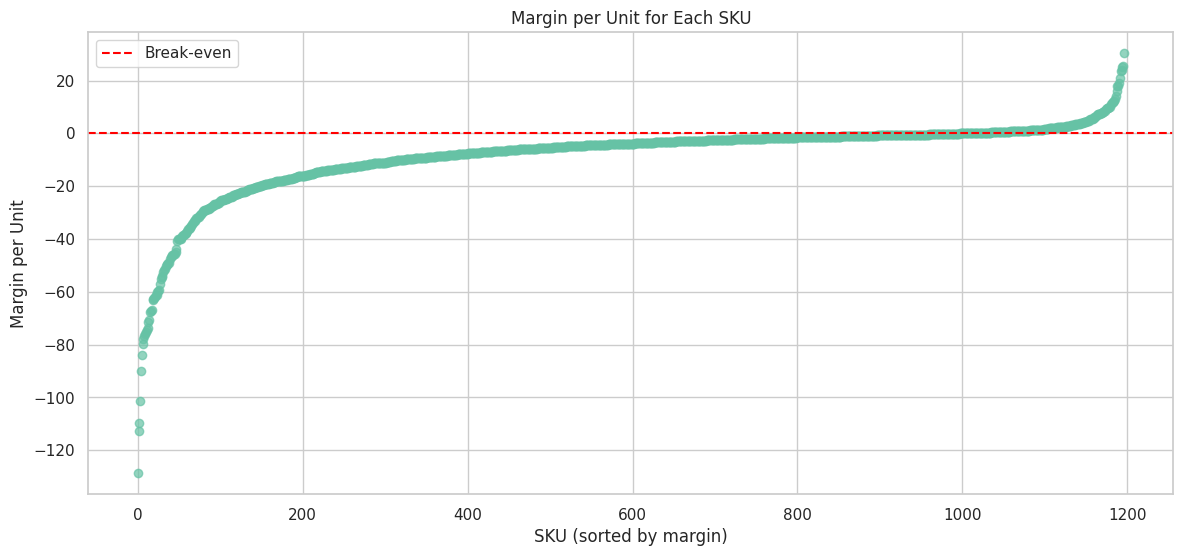

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Histogram of Margin per Unit ---
plt.figure(figsize=(10,6))
sns.histplot(sku_price_compare['margin_per_unit'], bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.title("Distribution of Margin per Unit across SKUs")
plt.xlabel("Margin per Unit (Selling - Procurement)")
plt.ylabel("Number of SKUs")
plt.legend()
plt.show()

# --- Scatter Plot by SKU ---
sku_price_compare_sorted = sku_price_compare.sort_values('margin_per_unit').reset_index(drop=True)

plt.figure(figsize=(14,6))
plt.scatter(range(len(sku_price_compare_sorted)), sku_price_compare_sorted['margin_per_unit'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Break-even')
plt.title("Margin per Unit for Each SKU")
plt.xlabel("SKU (sorted by margin)")
plt.ylabel("Margin per Unit")
plt.legend()
plt.show()

In [41]:
# Count SKUs that are profitable (loss_flag == False)
num_profitable_skus = sku_price_compare[sku_price_compare['loss_flag'] == False]['sku_id'].nunique()

print("Number of SKUs that are profitable or break-even:", num_profitable_skus)

Number of SKUs that are profitable or break-even: 195


In [42]:
# Total revenue from all SKUs
total_revenue = master['total_cost'].sum()

# Revenue from profitable SKUs
profitable_skus = sku_price_compare[sku_price_compare['loss_flag'] == False]['sku_id']
profitable_revenue = master[master['sku_id'].isin(profitable_skus)]['total_cost'].sum()

# Percentage share
profitable_share_pct = (profitable_revenue / total_revenue) * 100

print(f"Profitable SKUs contribute {profitable_share_pct:.2f}% of total revenue")

Profitable SKUs contribute 17.78% of total revenue


Dartment Wise Margins

In [43]:
# --- Step 1: Merge SKU margin info into master ---
sku_margin_info = sku_price_compare[['sku_id','avg_procurement_price','avg_selling_price','margin_per_unit']]
master_margin = master.merge(sku_margin_info, on='sku_id', how='left')

# --- Step 2: Compute margin per transaction ---
master_margin['transaction_margin'] = (master_margin['avg_selling_price'] - master_margin['avg_procurement_price']) * master_margin['quantity_consumed']

# --- Step 3: Aggregate department-level analysis ---
dept_margin = master_margin.groupby('dept_dept_name').agg(
    total_revenue=('total_cost','sum'),
    total_procurement_cost=('avg_procurement_price', lambda x: (x * master_margin.loc[x.index,'quantity_consumed']).sum()),
    total_margin=('transaction_margin','sum'),
    transactions=('transaction_id','count'),
    unique_skus=('sku_id','nunique')
).reset_index()

# --- Step 4: Margin % ---
dept_margin['margin_pct'] = (dept_margin['total_margin'] / dept_margin['total_revenue']) * 100

# --- Step 5: Display ---
from IPython.display import display
display(dept_margin.sort_values('margin_pct'))

,dept_dept_name,total_revenue,total_procurement_cost,total_margin,transactions,unique_skus,margin_pct
7,Oncology,1.895049e+07,2.339155e+07,-4.160286e+06,81510,1197,-21.953447
2,General Surgery,2.335285e+07,2.740531e+07,-3.996055e+06,77226,1197,-17.111637
8,Orthopedics,2.418245e+07,2.835791e+07,-4.113236e+06,80635,1197,-17.009180
9,Pediatrics,1.902441e+07,2.211476e+07,-3.052895e+06,82467,1197,-16.047250
6,Obstetrics & Gynecology,1.795908e+07,2.090553e+07,-2.881748e+06,77675,1197,-16.046191
5,Nephrology,1.759761e+07,2.052503e+07,-2.809238e+06,77055,1197,-15.963749
4,Internal Medicine,1.780867e+08,2.036942e+08,-2.555740e+07,659924,1197,-14.351102
3,ICU,1.567981e+07,1.757440e+07,-1.939387e+06,82982,1197,-12.368689
1,Emergency Medicine,8.246845e+07,8.984836e+07,-8.544662e+06,392620,1197,-10.361128
0,Cardiology,2.764244e+08,3.024384e+08,-2.547437e+07,1021862,1197,-9.215675


/tmp/ipython-input-1362207058.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_margin.sort_values('margin_pct'), x='dept_dept_name', y='margin_pct',


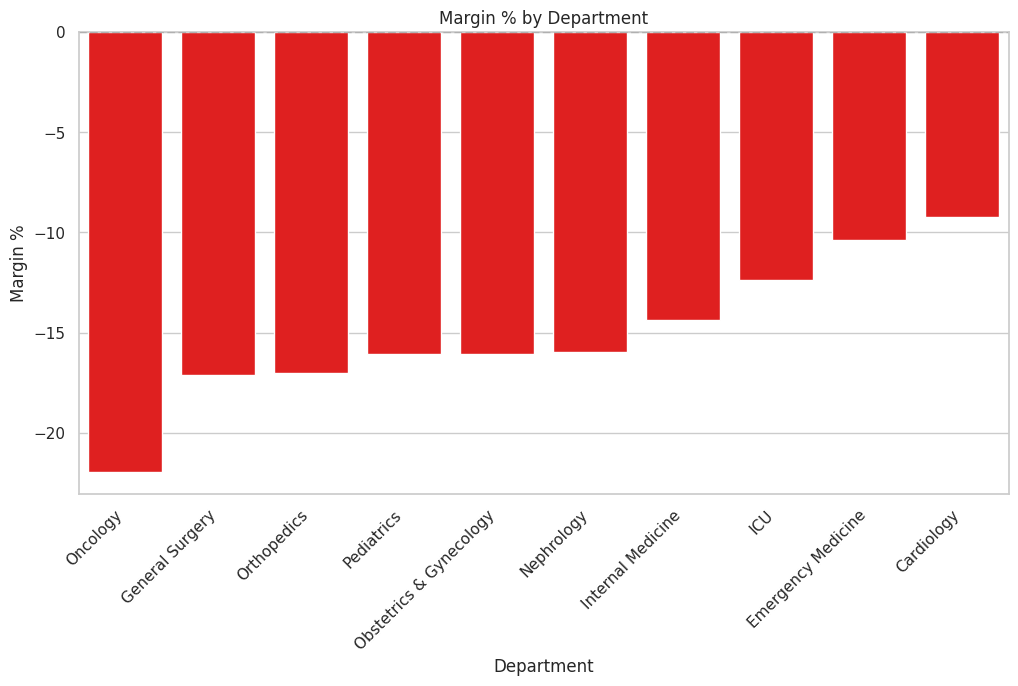

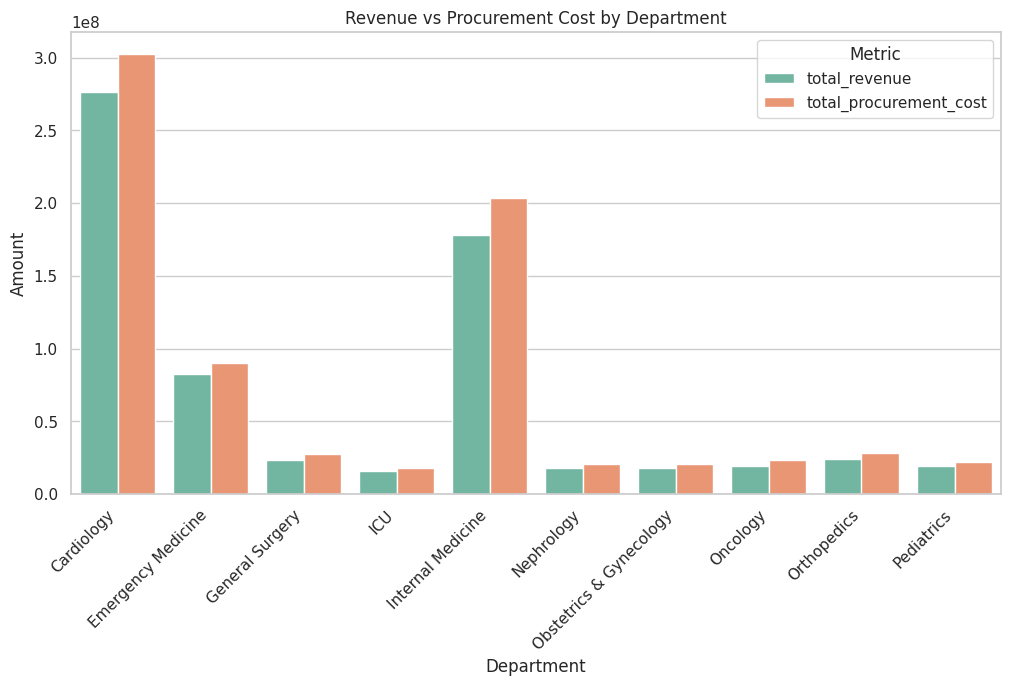

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Margin % by Department ---
plt.figure(figsize=(12,6))
sns.barplot(data=dept_margin.sort_values('margin_pct'), x='dept_dept_name', y='margin_pct',
            palette=['red' if x < 0 else 'green' for x in dept_margin.sort_values('margin_pct')['margin_pct']])
plt.xticks(rotation=45, ha="right")
plt.title("Margin % by Department")
plt.ylabel("Margin %")
plt.xlabel("Department")
plt.axhline(0, color='black', linestyle='--')
plt.show()

# --- 2. Revenue vs Procurement Cost ---
dept_rev_cost = dept_margin[['dept_dept_name','total_revenue','total_procurement_cost']].melt(id_vars='dept_dept_name')
plt.figure(figsize=(12,6))
sns.barplot(data=dept_rev_cost, x='dept_dept_name', y='value', hue='variable')
plt.xticks(rotation=45, ha="right")
plt.title("Revenue vs Procurement Cost by Department")
plt.ylabel("Amount")
plt.xlabel("Department")
plt.legend(title="Metric")
plt.show()